# GDS Project Data collection and proccesing

### Environment setup
+ Dokumentieren 

## Analyse
### Korrelation zwischen
+ Saisonal
+ Tageszeit (Peaks zum beispiel)
+ Wochentag
+ (Lichtverhältnisse)
+ Stadtteil
+ Beteiligte Fahrzeugtypen
### Cluster Analyse
+ K nearest or anything
### Further ideas
+ Monte Carlo test

In [370]:
# csv file laden
import geopandas as gpd
import pandas as pd
import seaborn as sns
import numpy as np
import shapely
import esda
from pysal.lib import weights
from splot.esda import moran_scatterplot, lisa_cluster, plot_local_autocorrelation, plot_moran
from splot.libpysal import plot_spatial_weights
from scipy.stats import pearsonr, spearmanr, chi2_contingency
from sklearn.cluster import DBSCAN
import osmnx as ox
import contextily as cx
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [371]:
df = gpd.read_file("Data/Shapefile/Unfallorte2021_LinRef.shp") #("work/gds/Data/Shapefile/Unfallorte2021_LinRef.shp")

In [372]:
df.head()
df_bike = df[df["IstRad"] == "1"]

In [373]:
df_bike.size

1864148

In [374]:
df_bike.head()

OBJECTID            UIDENTSTLA ULAND UREGBEZ UKREIS UGEMEINDE UJAHR UMONAT  \
2         3  01210610181013902021    01       0     61       007  2021     06   
3         4  01210524161013132021    01       0     53       041  2021     05   
4         5  01210529152013382022    01       0     55       032  2021     05   
6         7  01210512171013412021    01       0     56       037  2021     05   
7         8  01210325105132862021    01       0     56       043  2021     03   

  USTUNDE UWOCHENTAG  ... IstFuss IstKrad IstGkfz IstSonstig        LINREFX  \
2      13          5  ...       0       0       0          1  527231.388501   
3      11          2  ...       0       0       0          0  614902.973625   
4      15          7  ...       0       0       0          0  617331.180263   
6      14          4  ...       0       0       0          0  540082.958405   
7      06          5  ...       0       0       0          0  555471.603000   

        LINREFY  XGCSWGS84  YGCSWGS84 USTRZUSTAN  \
2  5.972658e+06   9.414457  53.901645          0   
3  5.963897e+06  10.745101  53.810913          0   
4  5.996138e+06  10.794357  54.100018          0   
6  5.947625e+06   9.606790  53.675817          0   
7  5.943956e+06   9.839070  53.641432          0   

                         geometry  
2  POINT (527231.389 5972658.256)  
3  POINT (614902.974 5963896.514)  
4  POINT (617331.180 5996138.283)  
6  POINT (540082.958 5947624.890)  
7  POINT (555471.603 5943955.564)  

[5 rows x 26 columns]

In [375]:
df_bike.crs

<Derived Projected CRS: EPSG:25832>
Name: ETRS89 / UTM zone 32N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Europe between 6°E and 12°E: Austria; Belgium; Denmark - onshore and offshore; Germany - onshore and offshore; Norway including - onshore and offshore; Spain - offshore.
- bounds: (6.0, 38.76, 12.0, 84.33)
Coordinate Operation:
- name: UTM zone 32N
- method: Transverse Mercator
Datum: European Terrestrial Reference System 1989 ensemble
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

<AxesSubplot:>

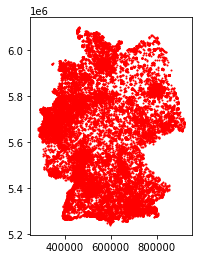

In [376]:
# plot points in df_bike
df_bike.plot(marker="o", color="red", markersize=1)

In [377]:
df_bike_hh = df_bike[df_bike["ULAND"] == "02"]

In [378]:
df_bike_hh.columns

Index(['OBJECTID', 'UIDENTSTLA', 'ULAND', 'UREGBEZ', 'UKREIS', 'UGEMEINDE',
       'UJAHR', 'UMONAT', 'USTUNDE', 'UWOCHENTAG', 'UKATEGORIE', 'UART',
       'UTYP1', 'ULICHTVERH', 'IstRad', 'IstPKW', 'IstFuss', 'IstKrad',
       'IstGkfz', 'IstSonstig', 'LINREFX', 'LINREFY', 'XGCSWGS84', 'YGCSWGS84',
       'USTRZUSTAN', 'geometry'],
      dtype='object')

In [379]:
df_bike_hh

OBJECTID            UIDENTSTLA ULAND UREGBEZ UKREIS UGEMEINDE UJAHR  \
2467        2468  02210923000023355720    02       4     02       403  2021   
2468        2469  02210221000031996600    02       4     07       417  2021   
2487        2488  02210820000025295600    02       2     05       216  2021   
2500        2501  02210701000024207620    02       3     06       318  2021   
2516        2517  02210920000021355480    02       2     03       209  2021   
...          ...                   ...   ...     ...    ...       ...   ...   
141586    141587  02211203000038501090    02       5     18       526  2021   
141605    141606  02211208000041506840    02       1     07       120  2021   
141612    141613  02211207000017485650    02       3     01       310  2021   
141616    141617  02211213000014513440    02       1     03       108  2021   
141620    141621  02211218000023518370    02       4     01       401  2021   

       UMONAT USTUNDE UWOCHENTAG  ... IstFuss IstKrad IstGkfz IstSonstig  \
2467       09      08          5  ...       0       0       0          0   
2468       02      13          1  ...       0       0       0          0   
2487       08      13          6  ...       0       0       0          0   
2500       07      08          5  ...       0       0       0          0   
2516       09      17          2  ...       0       0       0          0   
...       ...     ...        ...  ...     ...     ...     ...        ...   
141586     12      14          6  ...       0       0       0          0   
141605     12      08          4  ...       0       0       0          0   
141612     12      20          3  ...       0       0       0          0   
141616     12      12          2  ...       0       0       0          0   
141620     12      11          7  ...       0       0       0          0   

              LINREFX       LINREFY  XGCSWGS84  YGCSWGS84 USTRZUSTAN  \
2467    565121.940893  5.938776e+06   9.983936  53.593767          0   
2468    568333.680711  5.935233e+06  10.031679  53.561524          0   
2487    559438.566107  5.935553e+06   9.897464  53.565479          0   
2500    562881.939129  5.941350e+06   9.950617  53.617176          1   
2516    562057.028042  5.935391e+06   9.936962  53.563717          0   
...               ...           ...        ...        ...        ...   
141586  577577.739670  5.940437e+06  10.172506  53.607001          0   
141605  568808.688370  5.934974e+06  10.038792  53.559133          1   
141612  563877.721687  5.935873e+06   9.964546  53.567837          1   
141616  565659.823535  5.934620e+06   9.991188  53.556355          1   
141620  564978.057412  5.937586e+06   9.981515  53.583095          0   

                              geometry  
2467    POINT (565121.941 5938775.540)  
2468    POINT (568333.681 5935233.337)  
2487    POINT (559438.566 5935552.950)  
2500    POINT (562881.939 5941349.834)  
2516    POINT (562057.028 5935390.608)  
...                                ...  
141586  POINT (577577.740 5940436.840)  
141605  POINT (568808.688 5934974.234)  
141612  POINT (563877.722 5935873.307)  
141616  POINT (565659.824 5934620.196)  
141620  POINT (564978.057 5937586.078)  

[2455 rows x 26 columns]

In [380]:
# get districts of hamburg from shapefile
df_districts = gpd.read_file("Data/hh_districts/Stadtteile_Hamburg.shp") #("work/gds/Data/hh_districts/Stadtteile_Hamburg.shp")

In [381]:
df_bike_hh.crs

<Derived Projected CRS: EPSG:25832>
Name: ETRS89 / UTM zone 32N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Europe between 6°E and 12°E: Austria; Belgium; Denmark - onshore and offshore; Germany - onshore and offshore; Norway including - onshore and offshore; Spain - offshore.
- bounds: (6.0, 38.76, 12.0, 84.33)
Coordinate Operation:
- name: UTM zone 32N
- method: Transverse Mercator
Datum: European Terrestrial Reference System 1989 ensemble
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [382]:
df_districts = df_districts.to_crs("EPSG:25832")

In [383]:
df_bike_hh["IstNurRad"] = df_bike_hh[["IstPKW", "IstGkfz", "IstFuss", "IstKrad", "IstSonstig"]].apply(lambda x: 1 if pd.to_numeric(x).sum() == 0 else 0, axis=1)

/opt/conda/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


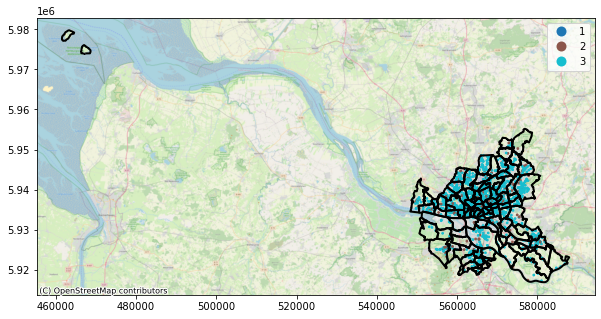

In [384]:
# color legend by 'UKATEGORIE'
fig, ax = plt.subplots(figsize=(10, 10))
df_bike_hh.plot(ax=ax, column="UKATEGORIE", legend=True, markersize=3)
# add districts
df_districts.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=2)
# add basemap
cx.add_basemap(ax, source=cx.providers.OpenStreetMap.Mapnik, crs=df_bike_hh.crs.to_string())


## KDE plot

In [385]:
# Drop islands (Neuwerk)
df_districts.drop(df_districts[df_districts['stadtteil_'] == 'Neuwerk'].index, inplace = True)

In [386]:
# Get outside borders of Hamburg by joining all polygons
for i, pol in enumerate(df_districts['geometry']):
    if i == 0:
        x = pol
    else:
        x = x.union(pol)

border_hh = gpd.GeoDataFrame({'geometry': x})

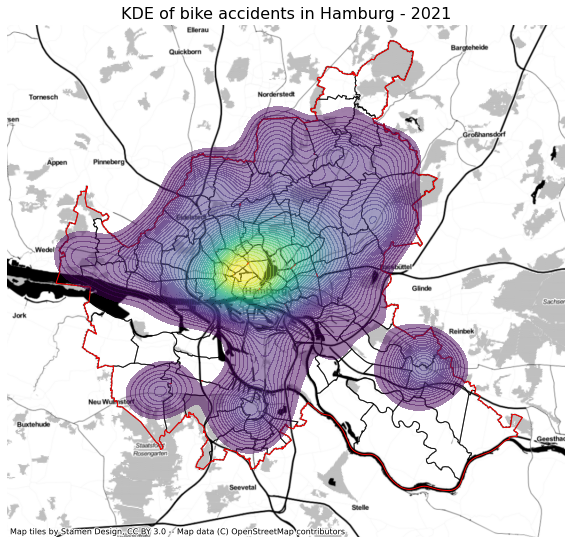

In [387]:
# Compute and display KDE of distribution of properties 
#sns.kdeplot(x=df_bike_hh['LINREFX'], y=df_bike_hh['LINREFY'], n_levels=50, fill=True, cmap='BuPu')
# Setup figure and axis
#fig, ax = plt.subplots(1, figsize=(12, 12))
ax = df_districts.plot(facecolor = 'none', edgecolor='black', alpha=0.7, linewidth=1, figsize = (10,10))
border_hh.plot(facecolor = 'none', edgecolor = 'red', ax = ax)
# Add KDE layer that displays probability surface
sns.kdeplot(x=df_bike_hh['LINREFX'], y=df_bike_hh['LINREFY'], n_levels=50, fill=True, alpha=0.5, cmap='viridis', ax = ax) 
ax.set_axis_off()
#ax.set_xlim(540000, 590000)
#ax.set_ylim(5.91, 5.96)
cx.add_basemap(ax, crs=df_bike_hh.crs, source=cx.providers.Stamen.Toner) #cx.providers.CartoDB.DarkMatterNoLabels) #providers.OpenStreetMap.Mapnik) 
ax.set_title("KDE of bike accidents in Hamburg - 2021",fontsize = 16)
plt.show() #plt.savefig('KDE_darkmatter.png') #'KDE_stamentoner.png') #'KDE_mapnik.png')

## Correlation matrix - Pearson, Spearman & Cramer's V

In [389]:
# correlation matrix of bike accidents in hamburg
# columns to use
cols = ["UKATEGORIE", "UART", "UMONAT", "USTUNDE", "UWOCHENTAG", "UTYP1", "ULICHTVERH", "IstPKW", "IstKrad", "IstGkfz", "IstSonstig", "IstNurRad"]

# filter by cols
df_bike_hh_corr = df_bike_hh[cols]

# convert to int
df_bike_hh_corr = df_bike_hh_corr.astype(int)

# calculate correlation matrix for categorical variables
corr = df_bike_hh_corr.corr(method="spearman")


In [390]:
# empty correlation matrix
corr = np.zeros((len(cols), len(cols)))

# Lists to identify scale level of features below
metric = ["UMONAT", "USTUNDE", "IstPKW", "IstKrad", "IstGkfz", "IstSonstig"]
ordinal = ["UKATEGORIE", "ULICHTVERH", "USTRZUSTAN"]
nominal = ["UART", "UWOCHENTAG", "UTYP1"]

# For loop over all columns
for i, col1 in enumerate(cols):
    for j, col2 in enumerate(cols):
        # If both columns are metric
        if col1 in metric and col2 in metric:
            # Compute pearsons correlation coefficient
            corr[i,j] = pearsonr(df_bike_hh_corr[col1], df_bike_hh_corr[col2])[0]
        # If both columns are ordinal or one is ordinal and the other metric
        elif col1 in metric + ordinal and col2 in metric + ordinal:
            # Compute spearmans correlation coefficient
            corr[i,j] = spearmanr(df_bike_hh_corr[col1], df_bike_hh_corr[col2])[0]
        # For all other combinations (anything that involves at least one nominal variable)
        else:
            # If possible compute Cramer's V
            try:
                # Create contingency table
                arr = np.array(pd.crosstab(index=df_bike_hh_corr[col1], columns=df_bike_hh_corr[col2]))
                # Compute Cramer's V via chi squared divided by product of number of observations and minimum of rows or columns -1 in contingency table
                # Finally square root
                corr[i,j] = np.sqrt(chi2_contingency(arr)[0]/(df_bike_hh_corr.shape[0] * (min(arr.shape)-1)))
            # If requirements for chi squared are not met, replace value in correlation matrix with nan
            except ValueError:
                corr[i,j] = np.nan

In [391]:
corr_df = pd.DataFrame(corr, columns = cols, index = cols)
corr_df

UKATEGORIE      UART    UMONAT   USTUNDE  UWOCHENTAG     UTYP1  \
UKATEGORIE    1.000000  0.065377  0.011443 -0.007444    0.057930  0.057116   
UART          0.065377  1.000000  0.077458  0.120483    0.071055  0.645227   
UMONAT        0.011443  0.077458  1.000000 -0.049407    0.096505  0.080561   
USTUNDE      -0.007444  0.120483 -0.049407  1.000000    0.146635  0.132695   
UWOCHENTAG    0.057930  0.071055  0.096505  0.146635    1.000000  0.074396   
UTYP1         0.057116  0.645227  0.080561  0.132695    0.074396  1.000000   
ULICHTVERH    0.004282  0.094588  0.165269  0.181074    0.068321  0.094381   
IstPKW        0.049074  0.635574  0.004826  0.012614    0.054472  0.621949   
IstKrad       0.029275  0.058644 -0.013668 -0.006850    0.045648  0.056266   
IstGkfz      -0.053836  0.118584  0.001364 -0.008004    0.074098  0.093730   
IstSonstig    0.015454  0.126212  0.012856 -0.007069    0.056229  0.158573   
IstNurRad     0.065259  0.692800  0.110102  0.179391    0.116470  0.713529   

            ULICHTVERH    IstPKW   IstKrad   IstGkfz  IstSonstig  IstNurRad  
UKATEGORIE    0.004282  0.049074  0.029275 -0.053836    0.015454   0.065259  
UART          0.094588  0.635574  0.058644  0.118584    0.126212   0.692800  
UMONAT        0.165269  0.004826 -0.013668  0.001364    0.012856   0.110102  
USTUNDE       0.181074  0.012614 -0.006850 -0.008004   -0.007069   0.179391  
UWOCHENTAG    0.068321  0.054472  0.045648  0.074098    0.056229   0.116470  
UTYP1         0.094381  0.621949  0.056266  0.093730    0.158573   0.713529  
ULICHTVERH    1.000000 -0.042192  0.011180 -0.017333   -0.007893   0.064410  
IstPKW       -0.042192  1.000000 -0.085905 -0.116564   -0.339482   0.671561  
IstKrad       0.011180 -0.085905  1.000000 -0.010080   -0.031191   0.053168  
IstGkfz      -0.017333 -0.116564 -0.010080  1.000000   -0.038280   0.067291  
IstSonstig   -0.007893 -0.339482 -0.031191 -0.038280    1.000000   0.219383  
IstNurRad     0.064410  0.671561  0.053168  0.067291    0.219383   0.999014

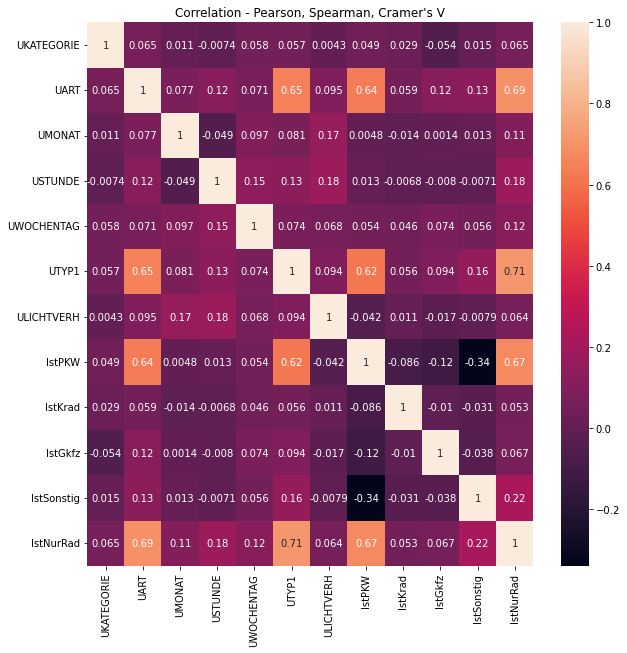

In [392]:
# plot correlation matrix
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(corr_df, annot=True, ax=ax)
plt.title("Correlation - Pearson, Spearman, Cramer's V")
plt.show()

## Correlation matrix - Spearman

In [393]:
df_bike_hh.columns

Index(['OBJECTID', 'UIDENTSTLA', 'ULAND', 'UREGBEZ', 'UKREIS', 'UGEMEINDE',
       'UJAHR', 'UMONAT', 'USTUNDE', 'UWOCHENTAG', 'UKATEGORIE', 'UART',
       'UTYP1', 'ULICHTVERH', 'IstRad', 'IstPKW', 'IstFuss', 'IstKrad',
       'IstGkfz', 'IstSonstig', 'LINREFX', 'LINREFY', 'XGCSWGS84', 'YGCSWGS84',
       'USTRZUSTAN', 'geometry', 'IstNurRad'],
      dtype='object')

In [394]:
corr

array([[ 1.        ,  0.0653766 ,  0.01144341, -0.0074435 ,  0.05792969,
         0.05711573,  0.00428183,  0.04907384,  0.02927544, -0.05383642,
         0.01545429,  0.06525876],
       [ 0.0653766 ,  1.        ,  0.07745805,  0.12048254,  0.071055  ,
         0.64522743,  0.0945875 ,  0.63557363,  0.05864377,  0.11858414,
         0.12621181,  0.69280028],
       [ 0.01144341,  0.07745805,  1.        , -0.04940695,  0.09650547,
         0.08056111,  0.16526924,  0.00482636, -0.01366779,  0.00136419,
         0.01285593,  0.11010227],
       [-0.0074435 ,  0.12048254, -0.04940695,  1.        ,  0.14663539,
         0.1326947 ,  0.18107446,  0.01261386, -0.00684966, -0.00800443,
        -0.00706898,  0.17939106],
       [ 0.05792969,  0.071055  ,  0.09650547,  0.14663539,  1.        ,
         0.07439606,  0.06832111,  0.05447193,  0.0456478 ,  0.07409756,
         0.05622916,  0.11646953],
       [ 0.05711573,  0.64522743,  0.08056111,  0.1326947 ,  0.07439606,
         1.        ,  

<AxesSubplot:>

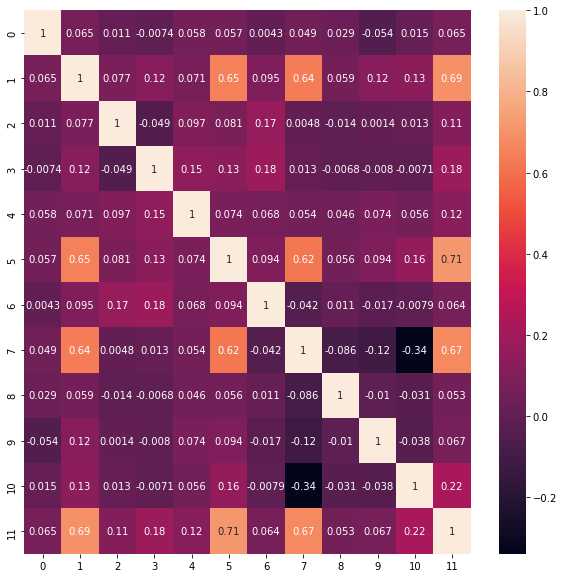

In [395]:
# plot correlation matrix
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(corr, annot=True, ax=ax)


## Exploratory Data Analysis 
### Univariate distributions

In [396]:
# columns to use
cols = ["UKATEGORIE", "UART", "UMONAT", "USTUNDE", "UWOCHENTAG", "UTYP1", "ULICHTVERH", "IstPKW", "IstKrad", "IstGkfz", "IstSonstig", "USTRZUSTAN"]

# filter by cols
df_bike_hh_corr = df_bike_hh[cols]

for col in cols:
    df_bike_hh_corr[col] = df_bike_hh_corr[col].astype('int')

/tmp/ipykernel_5406/1890377553.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bike_hh_corr[col] = df_bike_hh_corr[col].astype('int')


/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/seab

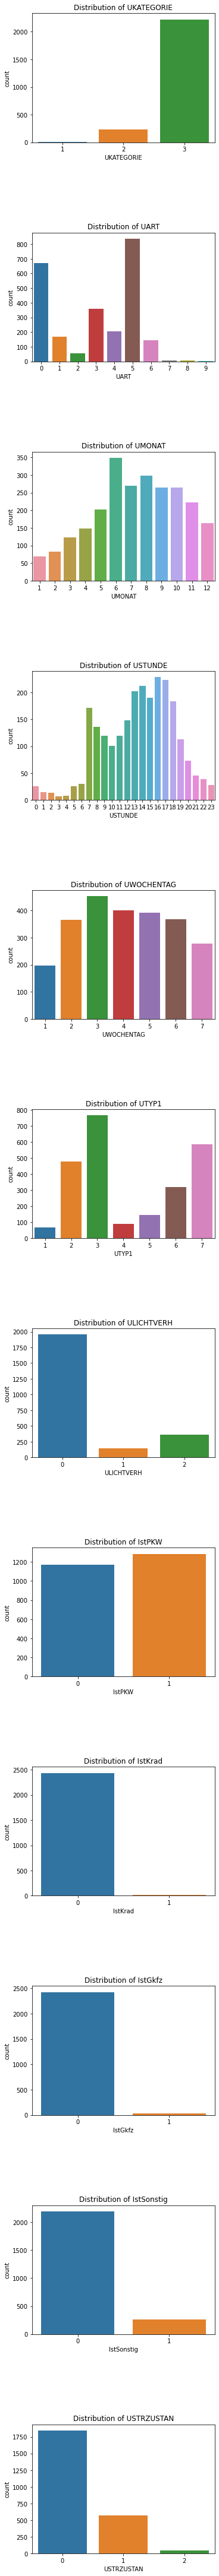

In [397]:
fig, axs = plt.subplots(len(cols), figsize = (5,len(cols)*5))
plt.tight_layout()
plt.subplots_adjust(hspace=0.7)

for i, col in enumerate(cols):
    sns.countplot(df_bike_hh_corr[col], ax = axs[i])
    #axs[i].hist(df_bike_hh_corr[col])
    axs[i].set_title(f'Distribution of {col}')
    
plt.show()

### Bivariate Distributions

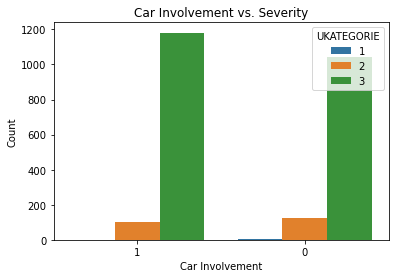

In [398]:
car_involvement = df_bike_hh['IstPKW']
severity = df_bike_hh['UKATEGORIE']
# sort severity
severity = severity.sort_values()

# Create a bar chart
sns.countplot(x=car_involvement, hue=severity)
plt.xlabel('Car Involvement')
plt.ylabel('Count')
plt.title('Car Involvement vs. Severity')
plt.show()

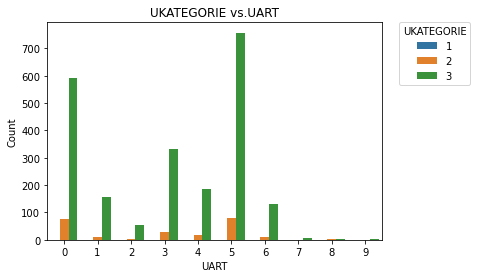

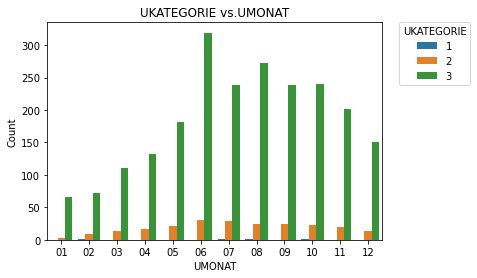

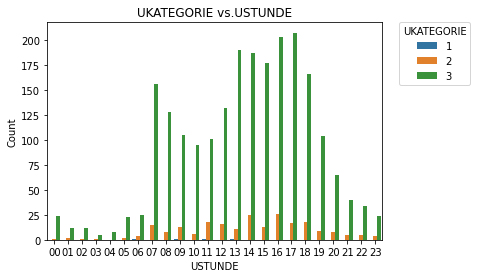

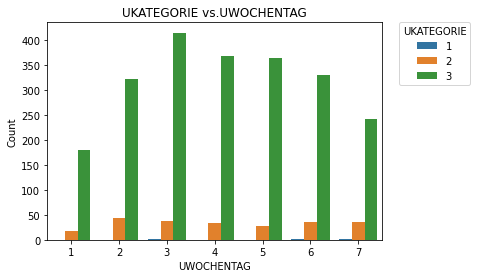

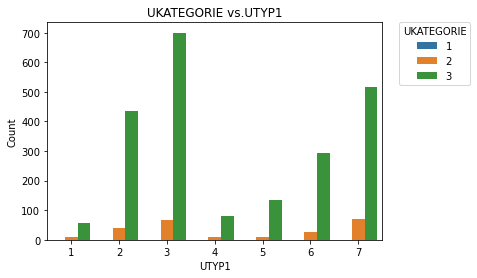

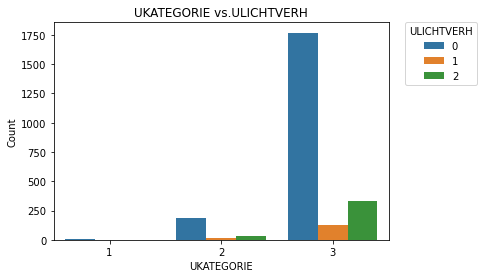

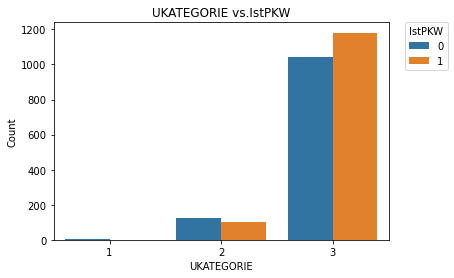

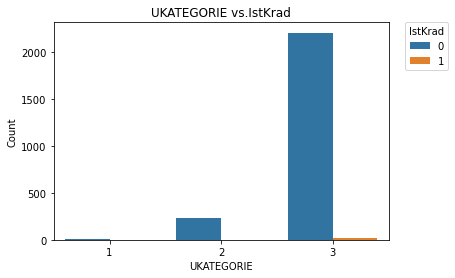

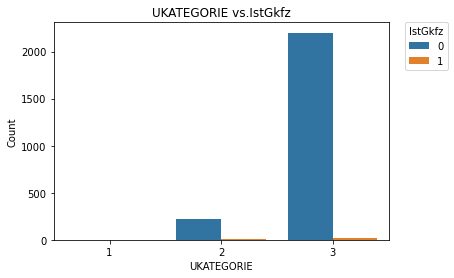

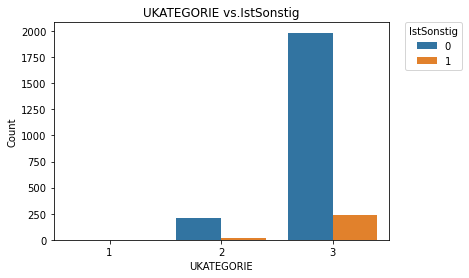

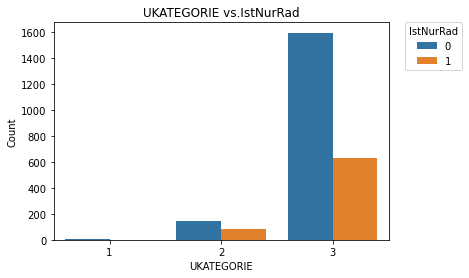

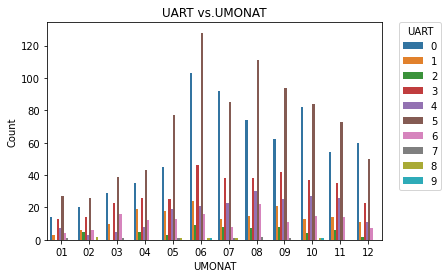

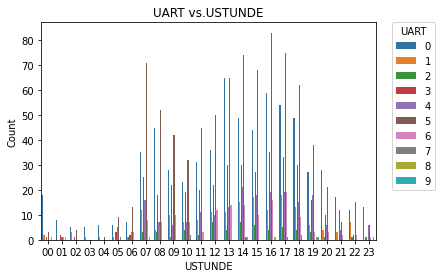

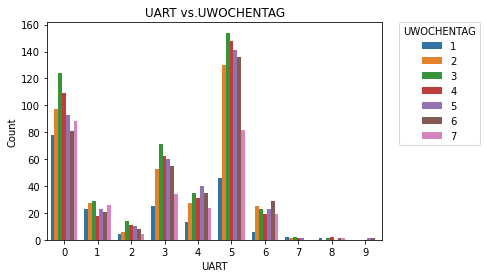

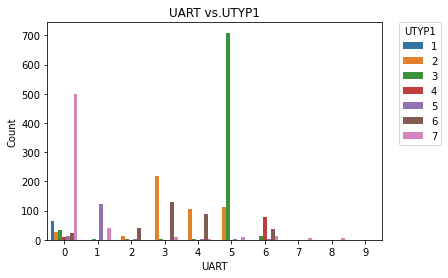

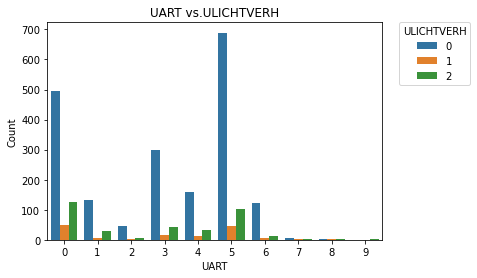

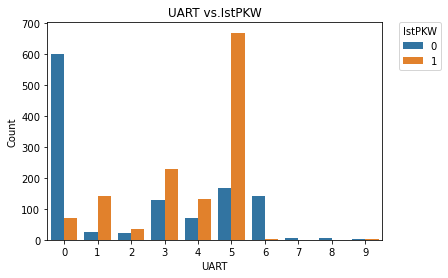

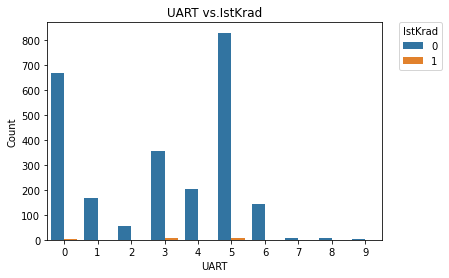

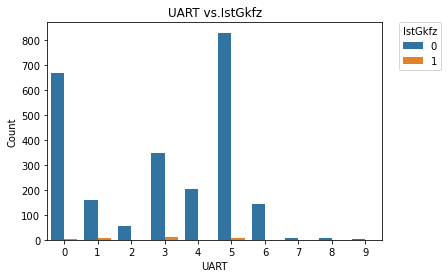

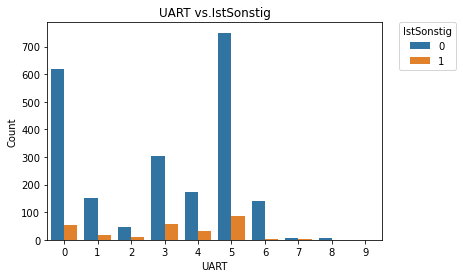

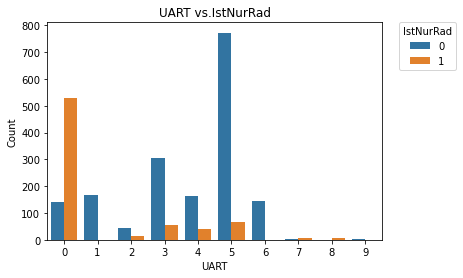

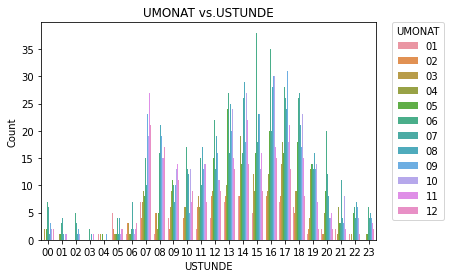

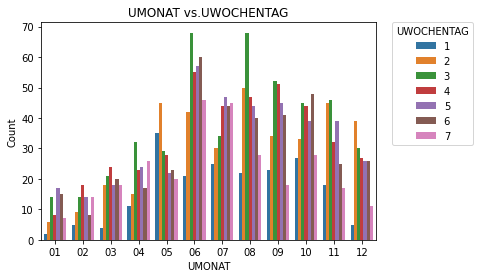

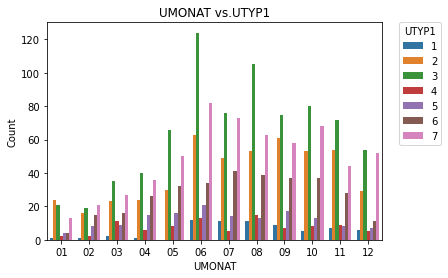

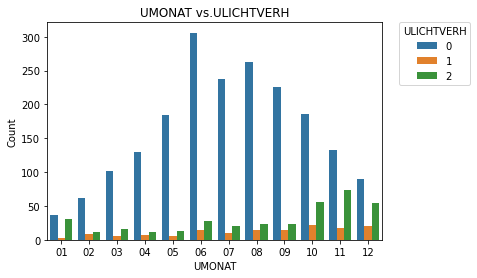

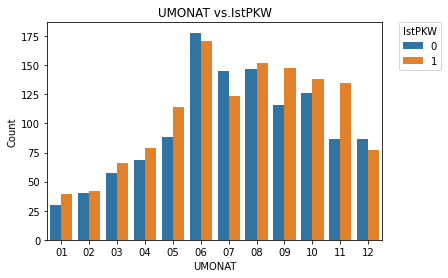

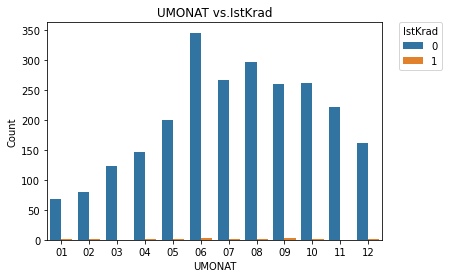

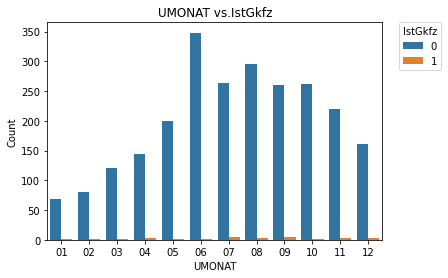

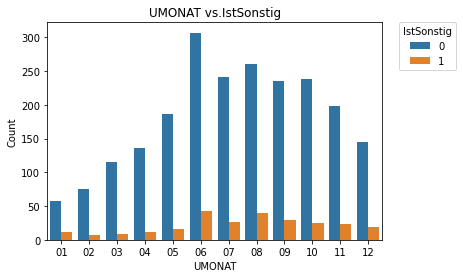

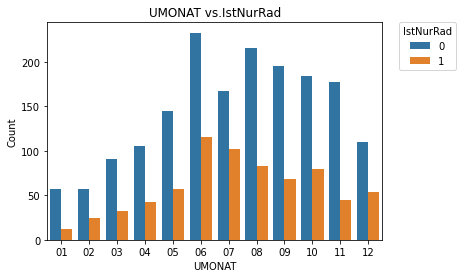

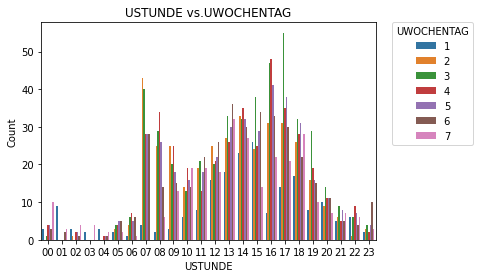

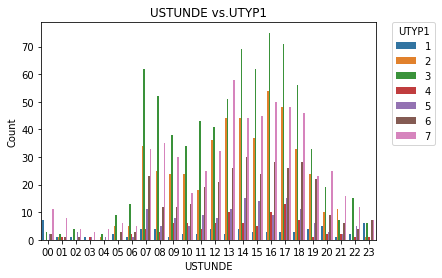

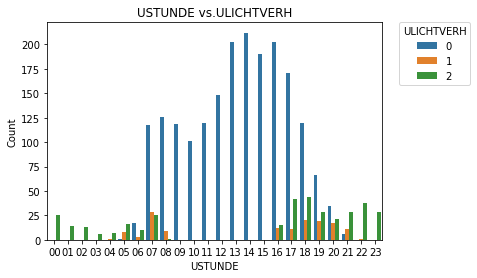

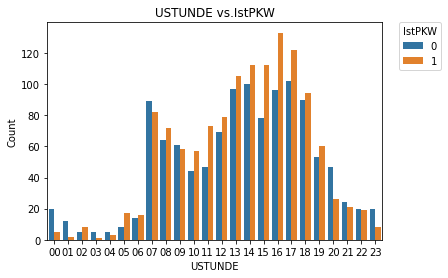

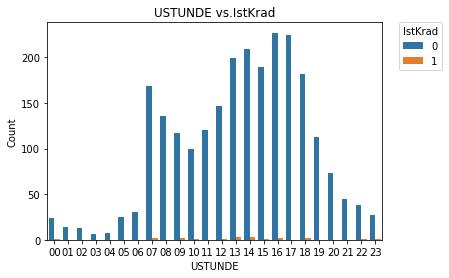

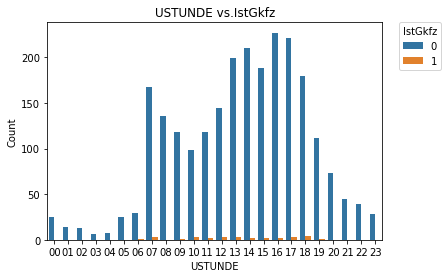

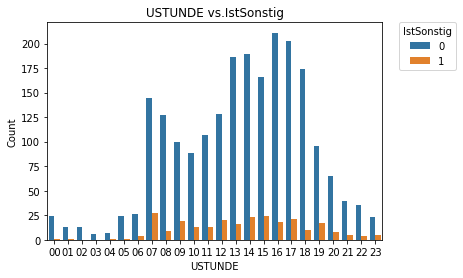

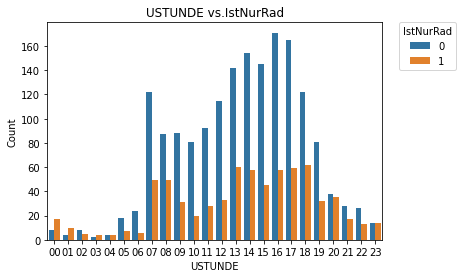

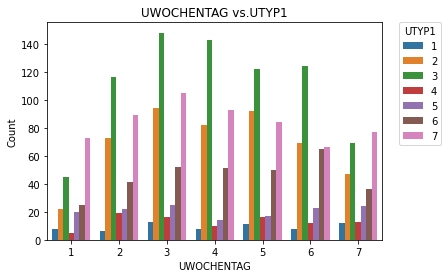

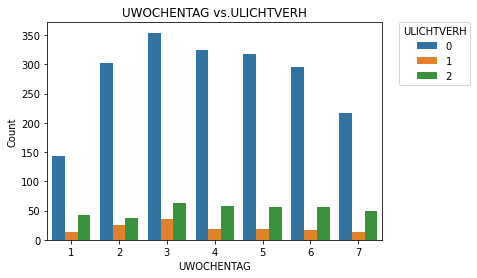

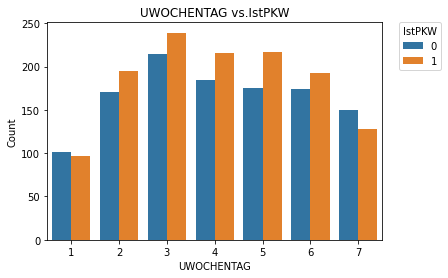

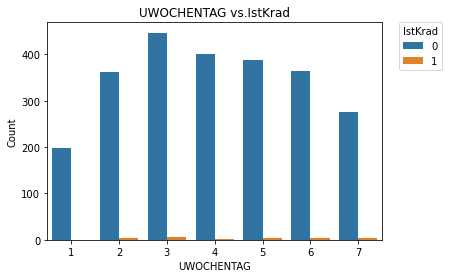

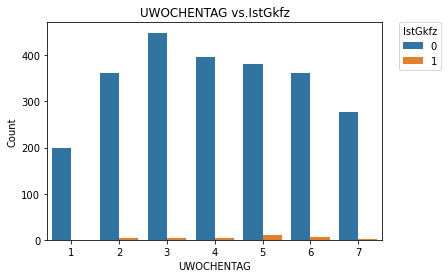

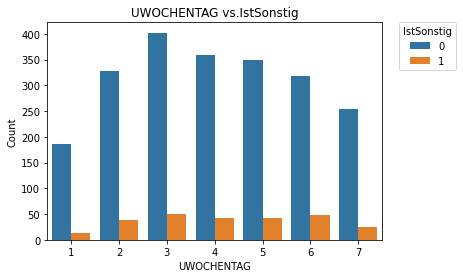

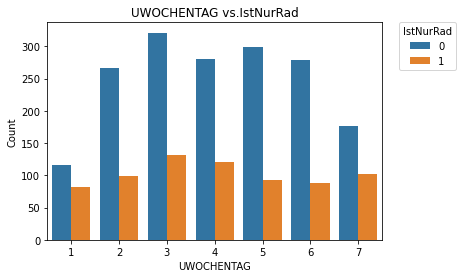

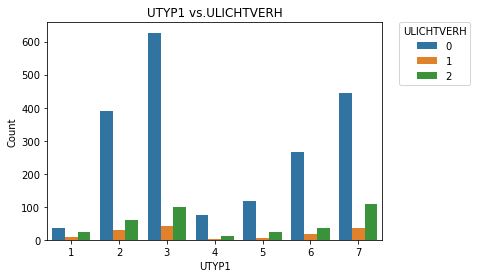

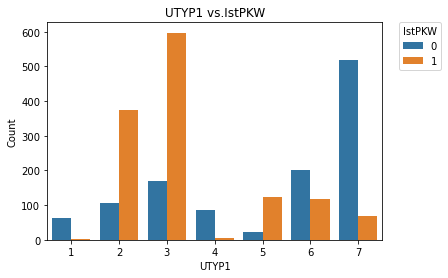

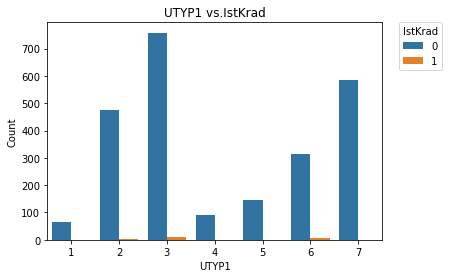

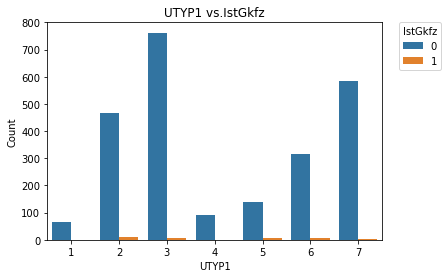

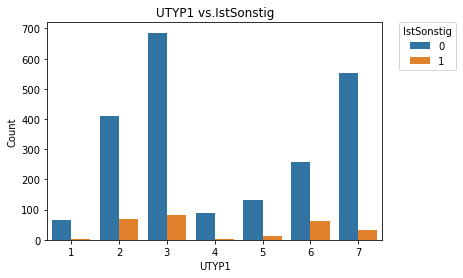

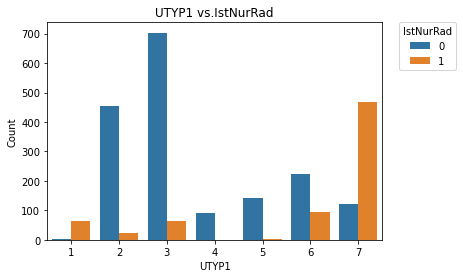

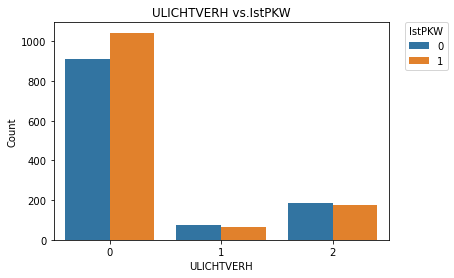

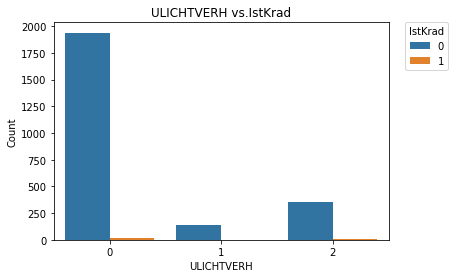

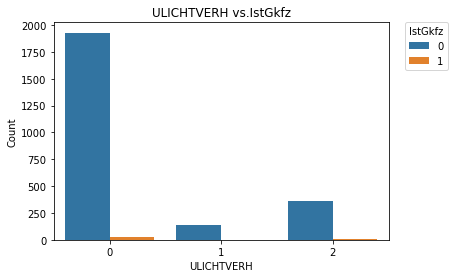

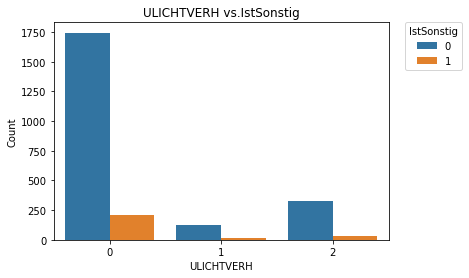

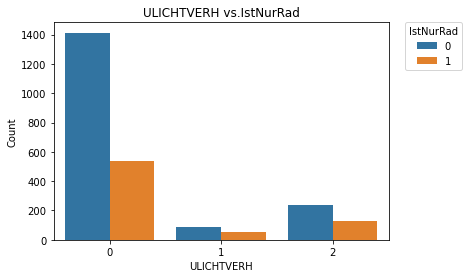

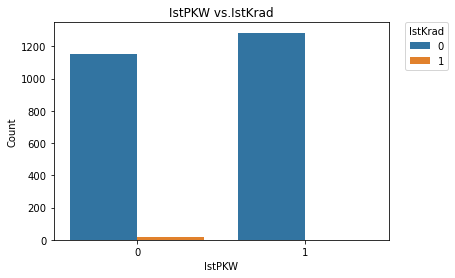

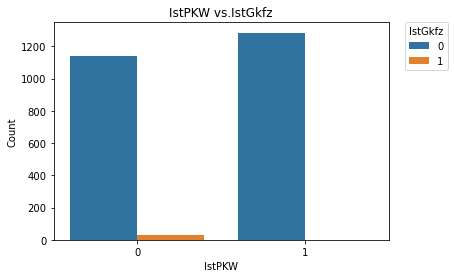

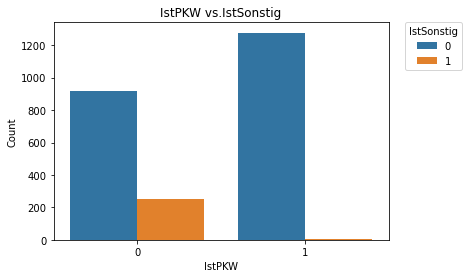

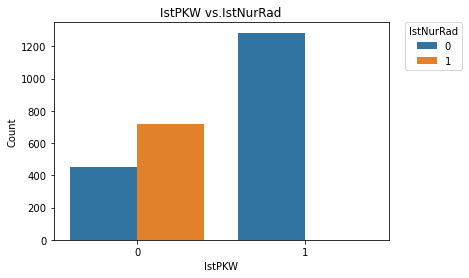

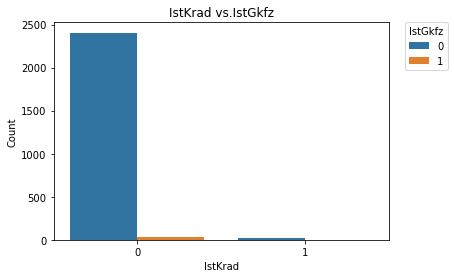

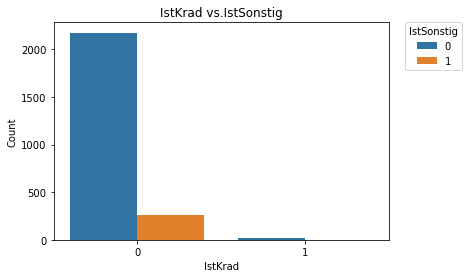

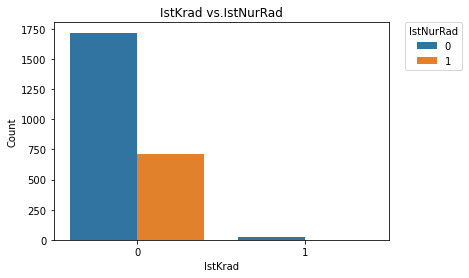

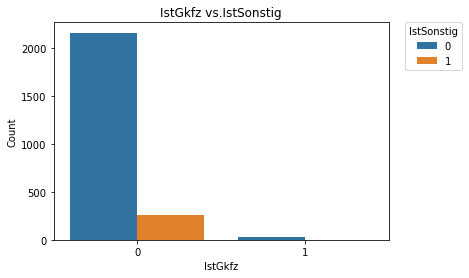

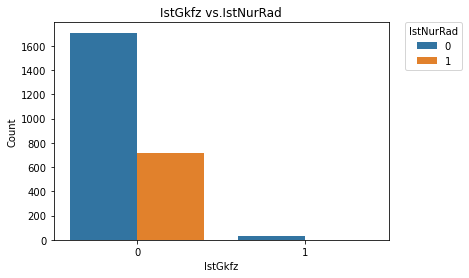

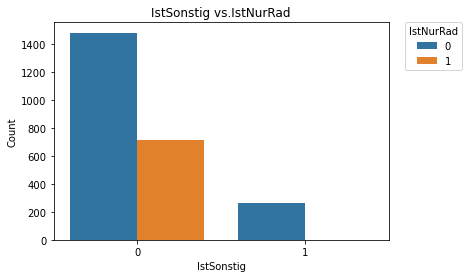

In [399]:
# plot categorical variables vs other categorical variables
# columns to use
cols = ["UKATEGORIE", "UART", "UMONAT", "USTUNDE", "UWOCHENTAG", "UTYP1", "ULICHTVERH", "IstPKW", "IstKrad", "IstGkfz", "IstSonstig", "IstNurRad"]

for col1 in cols:
    # continue from col1 + 1
    for col2 in cols[cols.index(col1) + 1:]:
        # plot categorical variables vs other categorical variables
        x = df_bike_hh[col1]
        y = df_bike_hh[col2]
        x = x.sort_values()
        y = y.sort_values()
        # Create a bar chart
        # use shorter as hue
        shorter = x if len(x.unique()) < len(y.unique()) else y
        longer = y if len(x.unique()) < len(y.unique()) else x
        sns.countplot(x=longer, hue=shorter, data=df_bike_hh)
        # place legend outside of plot showing title of hue

        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0, title=shorter.name)
        plt.xlabel(longer.name)
        plt.ylabel('Count')
        plt.title(col1 + ' vs.' + col2)
        plt.show()

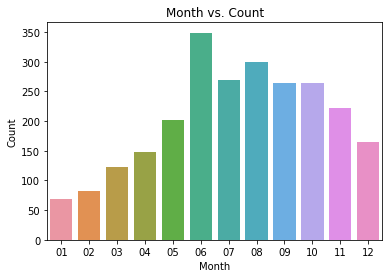

In [400]:
# plot count of values for "UMONAT"
x = df_bike_hh["UMONAT"]
x = x.sort_values()
sns.countplot(x=x)
plt.xlabel('Month')
plt.ylabel('Count')
plt.title('Month vs. Count')
plt.show()

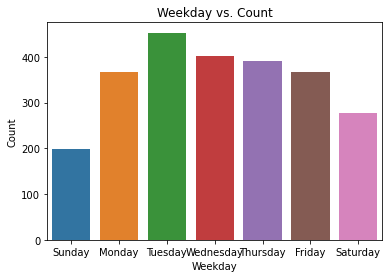

In [401]:
# plot count of values for "UWOCHENTAG"
x = df_bike_hh["UWOCHENTAG"]
x = x.sort_values()
days = {1: "Sunday",
        2: "Monday",
        3: "Tuesday",
        4: "Wednesday",
        5: "Thursday",
        6: "Friday",
        7: "Saturday"}

sns.countplot(x=x)
plt.xticks([0, 1, 2, 3, 4, 5, 6], [days[1], days[2], days[3], days[4], days[5], days[6], days[7]])
plt.xlabel('Weekday')
plt.ylabel('Count')
plt.title('Weekday vs. Count')
plt.show()

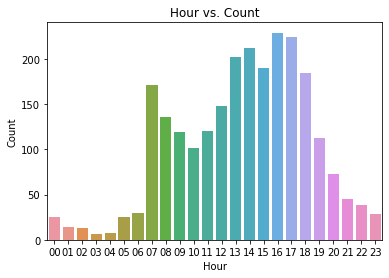

In [402]:
# plot count of values for "USTUNDE"
x = df_bike_hh["USTUNDE"]
x = x.sort_values()
sns.countplot(x=x)
plt.xlabel('Hour')
plt.ylabel('Count')
plt.title('Hour vs. Count')
plt.show()

In [403]:
# calculate ratio of "IstPKW" == 1 and "IstPKW" == 0 for each "STUNDE"
df_bike_hh["IstPKW"] = df_bike_hh["IstPKW"].astype(int)

ratio_dict = {}

for hour in df_bike_hh["USTUNDE"].unique():
    df_hour = df_bike_hh[df_bike_hh["USTUNDE"] == hour]
    # calculate ratio
    ratio = df_hour[df_hour["IstPKW"] == 1].size / df_hour[df_hour["IstPKW"] == 0].size
    ratio_dict[hour] = ratio
    # print("Ratio of IstPKW == 1 and IstPKW == 0 for hour {}: {}".format(hour, ratio))

/opt/conda/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


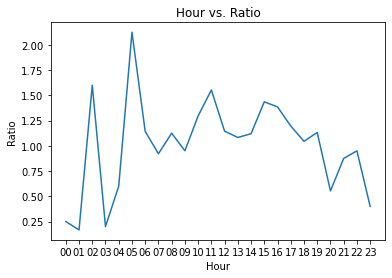

In [404]:
# plot ratio_dict
# sort by key (hour)
ratio_dict = {k: v for k, v in sorted(ratio_dict.items(), key=lambda item: item[0])}
sns.lineplot(x=list(ratio_dict.keys()), y=list(ratio_dict.values()))
plt.xlabel('Hour')
plt.ylabel('Ratio')
plt.title('Hour vs. Ratio')
plt.show()

In [405]:
# split "UMONAT" into seasons
df_bike_hh["UMONAT"] = df_bike_hh["UMONAT"].astype(int)
df_bike_hh["season"] = df_bike_hh["UMONAT"].apply(lambda x: "winter" if x in [1, 2, 12] else "spring" if x in [3, 4, 5] else "summer" if x in [6, 7, 8] else "autumn")

/opt/conda/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/opt/conda/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


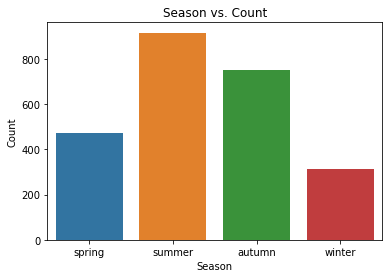

In [406]:
# plot count of values for "season"
x = df_bike_hh["season"]
sorter = ["spring", "summer", "autumn", "winter"]
x = x.sort_values(key=lambda column: column.map(lambda e: sorter.index(e)))
sns.countplot(x=x)
plt.xlabel('Season')
plt.ylabel('Count')
plt.title('Season vs. Count')
plt.show()

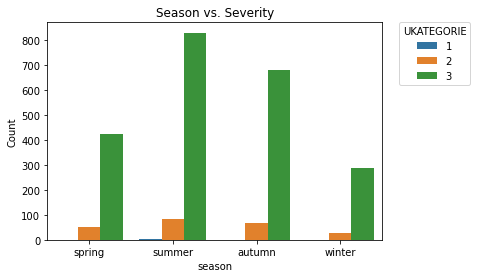

In [407]:
# plot season vs "UKATEGORIE"
x = df_bike_hh["season"]
y = df_bike_hh["UKATEGORIE"]
sorter = ["spring", "summer", "autumn", "winter"]
x = x.sort_values(key=lambda column: column.map(lambda e: sorter.index(e)))
y = y.sort_values()
# Create a bar chart
# use shorter as hue
shorter = x if len(x.unique()) < len(y.unique()) else y
longer = y if len(x.unique()) < len(y.unique()) else x
sns.countplot(x=longer, hue=shorter, data=df_bike_hh)
# place legend outside of plot showing title of hue
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0, title=shorter.name)
plt.xlabel(longer.name)
plt.ylabel('Count')
plt.title('Season vs. Severity')
plt.show()


In [408]:
# season vs ratio of severity

ratio_dict_severity = {}
for season in df_bike_hh["season"].unique():
    df_season = df_bike_hh[df_bike_hh["season"] == season]
    sum = df_season.size
    fatal_ratio = df_season[df_season["UKATEGORIE"] == "1"].size / sum
    severe_ratio = df_season[df_season["UKATEGORIE"] == "2"].size / sum
    slight_ratio = df_season[df_season["UKATEGORIE"] == "3"].size / sum
    
    ratio = [fatal_ratio, severe_ratio, slight_ratio]
    ratio_dict_severity[season] = ratio


In [409]:
ratio_dict_severity

{'autumn': [0.0013333333333333333, 0.09066666666666667, 0.908],
 'winter': [0.0031746031746031746, 0.08253968253968254, 0.9142857142857143],
 'summer': [0.0021810250817884407, 0.0916030534351145, 0.906215921483097],
 'spring': [0.0, 0.10570824524312897, 0.8942917547568711]}

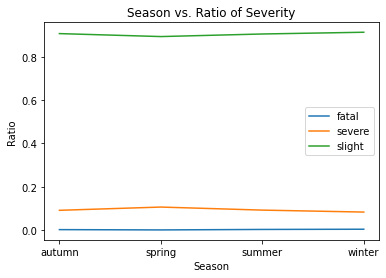

In [410]:
# plot ratio_dict_severity
# sort by key (season)
ratio_dict_severity = {k: v for k, v in sorted(ratio_dict_severity.items(), key=lambda item: item[0])}
sns.lineplot(x=list(ratio_dict_severity.keys()), y=[x[0] for x in list(ratio_dict_severity.values())], label="fatal")
sns.lineplot(x=list(ratio_dict_severity.keys()), y=[x[1] for x in list(ratio_dict_severity.values())], label="severe")
sns.lineplot(x=list(ratio_dict_severity.keys()), y=[x[2] for x in list(ratio_dict_severity.values())], label="slight")
plt.xlabel('Season')
plt.ylabel('Ratio')
plt.title('Season vs. Ratio of Severity')
plt.show()

### Cramers V

In [411]:
import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency

In [412]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

In [413]:
cols = ["UKATEGORIE", "UART", "UMONAT", "USTUNDE", "UWOCHENTAG", "UTYP1", "ULICHTVERH", "IstPKW", "IstKrad", "IstGkfz", "IstSonstig", "IstNurRad", "season"]

for col1 in cols:
    for col2 in cols[cols.index(col1) + 1:]:
        corr = cramers_v(df_bike_hh[col1], df_bike_hh[col2])
        if corr > 0.1:
            print("Correlation between {} and {}: {}".format(col1, col2, corr))

Correlation between UART and UTYP1: 0.6431658799428369
Correlation between UART and IstPKW: 0.632810826130587
Correlation between UART and IstGkfz: 0.10197526719262816
Correlation between UART and IstSonstig: 0.11075621299927914
Correlation between UART and IstNurRad: 0.6902890072819143
Correlation between UMONAT and ULICHTVERH: 0.22238954429473853
Correlation between UMONAT and season: 0.9983666791874573
Correlation between USTUNDE and UWOCHENTAG: 0.1102688274967186
Correlation between USTUNDE and ULICHTVERH: 0.5337590481319345
Correlation between USTUNDE and IstPKW: 0.11182352749623142
Correlation between USTUNDE and IstNurRad: 0.1510562783475137
Correlation between UWOCHENTAG and IstNurRad: 0.1054736763231398
Correlation between UTYP1 and IstPKW: 0.6201064819169803
Correlation between UTYP1 and IstSonstig: 0.15069718349795377
Correlation between UTYP1 and IstNurRad: 0.7119591970415156
Correlation between ULICHTVERH and season: 0.17895941246123856
Correlation between IstPKW and IstGk

### Spatial Autocorrelation

In [414]:
# detect islands in df_bike_hh geometry
# Create an empty GeoDataFrame to store the islands
islands = gpd.GeoDataFrame(columns=df_districts.columns)

# Loop over each polygon in the GeoDataFrame
for i, row in df_districts.iterrows():
    # Check if the polygon touches any other polygon
    touches = df_districts[df_districts.geometry.touches(row.geometry)]
    
    # If the polygon doesn't touch any other polygon, it's an island
    if touches.empty:
        # Add the island to the GeoDataFrame
        islands = islands.append(row, ignore_index=True)
        # remove the island from the original GeoDataFrame
        df_districts = df_districts.drop(i)

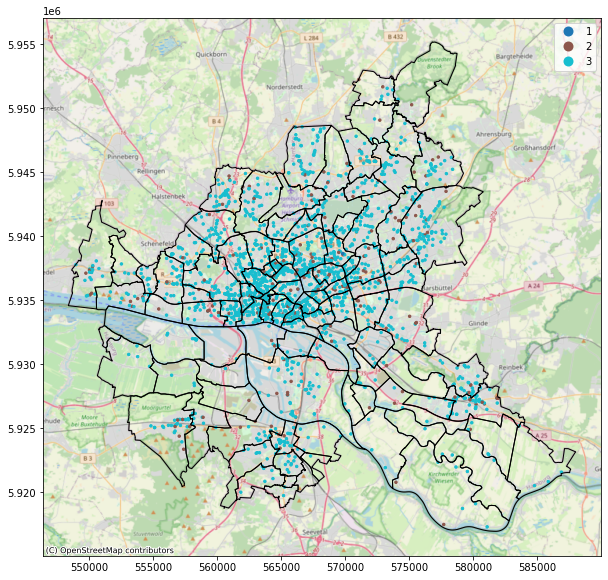

In [415]:
# color legend by 'UKATEGORIE'
fig, ax = plt.subplots(figsize=(10, 10))
df_bike_hh.plot(ax=ax, column="UKATEGORIE", legend=True, markersize=6)
# add districts
df_districts.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=1)
# add basemap
cx.add_basemap(ax, source=cx.providers.OpenStreetMap.Mapnik, crs=df_bike_hh.crs.to_string())


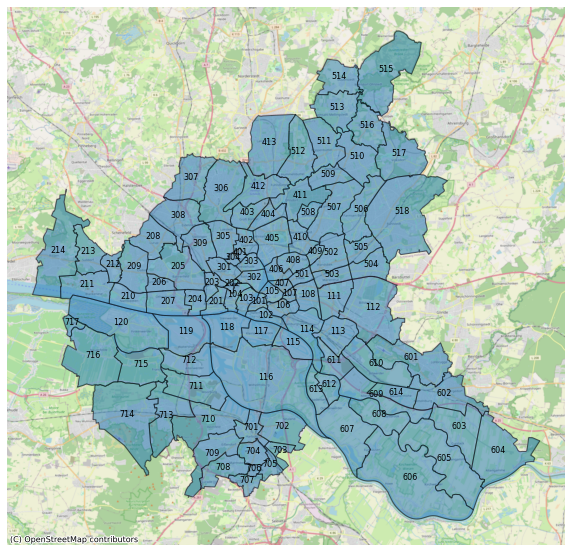

In [416]:
ax = df_districts.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')
cx.add_basemap(ax, zoom=12, source=cx.providers.OpenStreetMap.Mapnik, crs=df_bike_hh.crs.to_string())
ax.set_axis_off()
for idx, row in df_districts.iterrows():
    ax.annotate(text=row["stadttei_2"], xy=row['geometry'].centroid.coords[0], 
                horizontalalignment='center', fontsize=8, color='black')


In [417]:
df_districts

OBJECTID bezirk     bezirk_nam          stadtteil_ stadttei_1 stadttei_2  \
0           1      1  Hamburg-Mitte    Hamburg-Altstadt      02101        101   
1           2      1  Hamburg-Mitte           HafenCity      02102        102   
2           3      1  Hamburg-Mitte            Neustadt      02103        103   
3           4      1  Hamburg-Mitte           St. Pauli      02104        104   
4           5      1  Hamburg-Mitte           St. Georg      02105        105   
..        ...    ...            ...                 ...        ...        ...   
99        100      7        Harburg           Hausbruch      02713        713   
100       101      7        Harburg  Neugraben-Fischbek      02714        714   
101       102      7        Harburg             Francop      02715        715   
102       103      7        Harburg          Neuenfelde      02716        716   
103       104      7        Harburg               Cranz      02717        717   

       SHAPE_Leng    SHAPE_Area  \
0     9028.180532  3.676562e+06   
1    13902.691334  6.860720e+06   
2    11133.923114  6.395226e+06   
3    15968.675123  6.343533e+06   
4     9795.650670  5.155061e+06   
..            ...           ...   
99   34659.184329  2.770431e+07   
100  42482.635108  6.344999e+07   
101  23501.637669  2.486794e+07   
102  31946.432527  4.424464e+07   
103   9995.339044  3.768256e+06   

                                              geometry  
0    POLYGON ((566655.103 5933760.301, 566722.625 5...  
1    POLYGON ((566183.919 5932468.981, 566099.304 5...  
2    POLYGON ((565841.224 5934181.092, 565729.797 5...  
3    POLYGON ((563834.747 5933258.107, 563765.973 5...  
4    POLYGON ((567068.406 5933916.007, 567055.305 5...  
..                                                 ...  
99   POLYGON ((559335.214 5925124.684, 559331.386 5...  
100  POLYGON ((556513.916 5921502.868, 556488.926 5...  
101  POLYGON ((558377.088 5930115.476, 558381.359 5...  
102  POLYGON ((551927.877 5928219.428, 551922.431 5...  
103  POLYGON ((552445.343 5932065.963, 552431.310 5...  

[103 rows x 9 columns]

In [418]:
# add district to df_bike_hh based on geometry
df_bike_hh["bezirk"] = df_bike_hh["geometry"].apply(lambda x: df_districts[df_districts.geometry.contains(x)]["bezirk_nam"].values[0])
df_bike_hh["stadtteil"] = df_bike_hh["geometry"].apply(lambda x: df_districts[df_districts.geometry.contains(x)]["stadtteil_"].values[0])

/opt/conda/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/opt/conda/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [419]:
# add id column for districs in df_bike_hh
df_bike_hh["bezirk_id"] = df_bike_hh["bezirk"].apply(lambda x: df_districts[df_districts["bezirk_nam"] == x]["bezirk"].values[0])
df_bike_hh["stadtteil_id"] = df_bike_hh["stadtteil"].apply(lambda x: df_districts[df_districts["stadtteil_"] == x]["stadttei_2"].values[0])

/opt/conda/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/opt/conda/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [420]:
cols = ["UKATEGORIE", "UART", "UMONAT", "USTUNDE", "UWOCHENTAG", "UTYP1", "ULICHTVERH", "IstPKW", "IstKrad", "IstGkfz", "IstSonstig", "IstNurRad", "season", "stadtteil_id", "bezirk_id"]


for col1 in cols:
    for col2 in cols[cols.index(col1) + 1:]:
        corr = cramers_v(df_bike_hh[col1], df_bike_hh[col2])
        if corr > 0.1:
            print("Correlation between {} and {}: {}".format(col1, col2, corr))

Correlation between UART and UTYP1: 0.6431658799428369
Correlation between UART and IstPKW: 0.632810826130587
Correlation between UART and IstGkfz: 0.10197526719262816
Correlation between UART and IstSonstig: 0.11075621299927914
Correlation between UART and IstNurRad: 0.6902890072819143
Correlation between UMONAT and ULICHTVERH: 0.22238954429473853
Correlation between UMONAT and season: 0.9983666791874573
Correlation between USTUNDE and UWOCHENTAG: 0.1102688274967186
Correlation between USTUNDE and ULICHTVERH: 0.5337590481319345
Correlation between USTUNDE and IstPKW: 0.11182352749623142
Correlation between USTUNDE and IstNurRad: 0.1510562783475137
Correlation between UWOCHENTAG and IstNurRad: 0.1054736763231398
Correlation between UTYP1 and IstPKW: 0.6201064819169803
Correlation between UTYP1 and IstSonstig: 0.15069718349795377
Correlation between UTYP1 and IstNurRad: 0.7119591970415156
Correlation between ULICHTVERH and season: 0.17895941246123856
Correlation between IstPKW and IstGk

In [473]:
cat_cols = ["UKATEGORIE", "UART", "UMONAT", "USTUNDE", "UWOCHENTAG", "UTYP1", "ULICHTVERH", "IstPKW", "IstKrad", "IstGkfz", "IstSonstig", "IstNurRad", "season", "bezirk", "stadtteil"]

In [474]:
df_dummies = df_bike_hh.copy()
for col in cat_cols:
    dummies = pd.get_dummies(df_dummies[col], prefix=col, prefix_sep='_')
    df_dummies = pd.concat([df_dummies, dummies], axis=1)
    df_dummies = df_dummies.drop(col, axis=1)

In [475]:
df_dummies['motor'] = np.where((df_dummies['IstKrad_1'] == 1) | (df_dummies['IstPKW_1'] == 1) | (df_dummies['IstGkfz_1'] == 1), 1, 0)

In [476]:
df_grouped_bez = df_dummies.groupby(["bezirk_id"]).sum()
df_grouped_stadt = df_dummies.groupby(["stadtteil_id"]).sum()

In [477]:
df_districts

OBJECTID bezirk     bezirk_nam          stadtteil_ stadttei_1 stadttei_2  \
0           1      1  Hamburg-Mitte    Hamburg-Altstadt      02101        101   
1           2      1  Hamburg-Mitte           HafenCity      02102        102   
2           3      1  Hamburg-Mitte            Neustadt      02103        103   
3           4      1  Hamburg-Mitte           St. Pauli      02104        104   
4           5      1  Hamburg-Mitte           St. Georg      02105        105   
..        ...    ...            ...                 ...        ...        ...   
99        100      7        Harburg           Hausbruch      02713        713   
100       101      7        Harburg  Neugraben-Fischbek      02714        714   
101       102      7        Harburg             Francop      02715        715   
102       103      7        Harburg          Neuenfelde      02716        716   
103       104      7        Harburg               Cranz      02717        717   

       SHAPE_Leng    SHAPE_Area  \
0     9028.180532  3.676562e+06   
1    13902.691334  6.860720e+06   
2    11133.923114  6.395226e+06   
3    15968.675123  6.343533e+06   
4     9795.650670  5.155061e+06   
..            ...           ...   
99   34659.184329  2.770431e+07   
100  42482.635108  6.344999e+07   
101  23501.637669  2.486794e+07   
102  31946.432527  4.424464e+07   
103   9995.339044  3.768256e+06   

                                              geometry  
0    POLYGON ((566655.103 5933760.301, 566722.625 5...  
1    POLYGON ((566183.919 5932468.981, 566099.304 5...  
2    POLYGON ((565841.224 5934181.092, 565729.797 5...  
3    POLYGON ((563834.747 5933258.107, 563765.973 5...  
4    POLYGON ((567068.406 5933916.007, 567055.305 5...  
..                                                 ...  
99   POLYGON ((559335.214 5925124.684, 559331.386 5...  
100  POLYGON ((556513.916 5921502.868, 556488.926 5...  
101  POLYGON ((558377.088 5930115.476, 558381.359 5...  
102  POLYGON ((551927.877 5928219.428, 551922.431 5...  
103  POLYGON ((552445.343 5932065.963, 552431.310 5...  

[103 rows x 9 columns]

In [478]:
# group df_districts by bezirk
# group the GeoDataFrame by the 'district_id' column and dissolve the geometries into a single geometry using the 'unary_union' method
bez_geomtries = df_districts.groupby('bezirk')['geometry'].apply(lambda x: x.unary_union)

# convert the resulting series to a GeoDataFrame
dissolved_bez_gdf = gpd.GeoDataFrame(geometry=bez_geomtries)


In [479]:
dissolved_bez_gdf

geometry
bezirk                                                   
1       POLYGON ((566380.311 5925325.069, 566282.956 5...
2       POLYGON ((555651.304 5933510.967, 555337.017 5...
3       POLYGON ((565797.903 5934832.877, 565797.458 5...
4       POLYGON ((564391.545 5937420.714, 564382.192 5...
5       MULTIPOLYGON (((573346.824 5935754.906, 573342...
6       POLYGON ((573715.446 5920276.955, 573693.672 5...
7       POLYGON ((561453.250 5919328.943, 561178.819 5...

In [480]:
# add geomtry from df_districts
df_grouped_bez = df_grouped_bez.merge(dissolved_bez_gdf, left_on="bezirk_id", right_on="bezirk")
df_grouped_stadt = df_grouped_stadt.merge(df_districts, left_on="stadtteil_id", right_on="stadttei_2")

In [481]:
df_grouped_bez["bezirk_id"] = df_grouped_bez.index + 1

Continuing with Stadtteile, since there are only 7 Bezirke

In [482]:
w = weights.Queen.from_dataframe(df_grouped_stadt, idVariable="stadttei_2")

In [483]:
# Row standardize the matrix
w.transform = 'R'

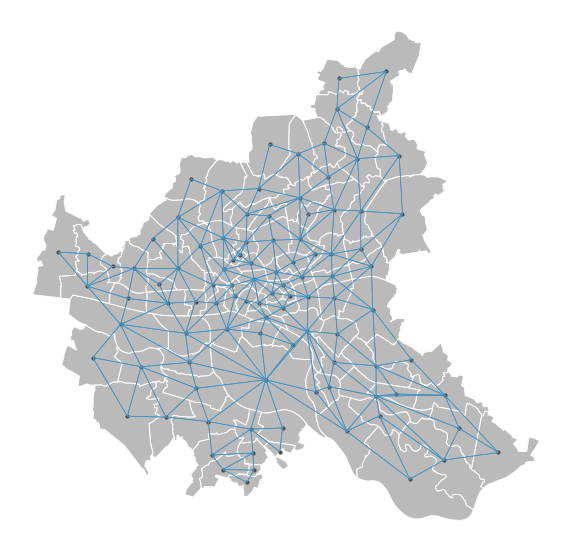

In [484]:
plot_spatial_weights(w, df_grouped_stadt, indexed_on="stadttei_2");

In [485]:
df_grouped_stadt.columns

Index(['OBJECTID_x', 'LINREFX', 'LINREFY', 'XGCSWGS84', 'YGCSWGS84',
       'UKATEGORIE_1', 'UKATEGORIE_2', 'UKATEGORIE_3', 'UART_0', 'UART_1',
       ...
       'motor', 'OBJECTID_y', 'bezirk', 'bezirk_nam', 'stadtteil_',
       'stadttei_1', 'stadttei_2', 'SHAPE_Leng', 'SHAPE_Area', 'geometry'],
      dtype='object', length=203)

In [486]:
df_grouped_stadt['w_motor'] = weights.lag_spatial(w, df_grouped_stadt['motor']) # we pass the weights object and the column with values to base the spatial lag on
df_grouped_stadt['motor_std'] = (df_grouped_stadt['motor'] - df_grouped_stadt['motor'].mean()) / df_grouped_stadt['motor'].std()
df_grouped_stadt['w_motor_std'] = weights.lag_spatial(w, df_grouped_stadt['motor_std'])

In [487]:
df_grouped_stadt['motor_ratio'] = df_grouped_stadt['w_motor'] / (df_grouped_stadt['IstPKW_0'] + df_grouped_stadt['IstPKW_1'])

In [488]:
df_grouped_stadt['w_motor_ratio'] = weights.lag_spatial(w, df_grouped_stadt['motor_ratio']) # we pass the weights object and the column with values to base the spatial lag on
df_grouped_stadt['motor_ratio_std'] = (df_grouped_stadt['motor_ratio'] - df_grouped_stadt['motor_ratio'].mean()) / df_grouped_stadt['motor_ratio'].std()
df_grouped_stadt['w_motor_ratio_std'] = weights.lag_spatial(w, df_grouped_stadt['motor_ratio_std'])

In [489]:
df_grouped_stadt["count"] = df_grouped_stadt["IstPKW_1"] + df_grouped_stadt["IstPKW_0"]

In [490]:
df_grouped_stadt['w_count'] = weights.lag_spatial(w, df_grouped_stadt['count']) # we pass the weights object and the column with values to base the spatial lag on
df_grouped_stadt['count_std'] = (df_grouped_stadt['count'] - df_grouped_stadt['count'].mean()) / df_grouped_stadt['count'].std()
df_grouped_stadt['w_count_std'] = weights.lag_spatial(w, df_grouped_stadt['count_std'])

In [491]:
mi = esda.Moran(df_grouped_stadt['w_count_std'], w)
print(mi.I)
print(mi.p_sim)

0.7312822383133449
0.001


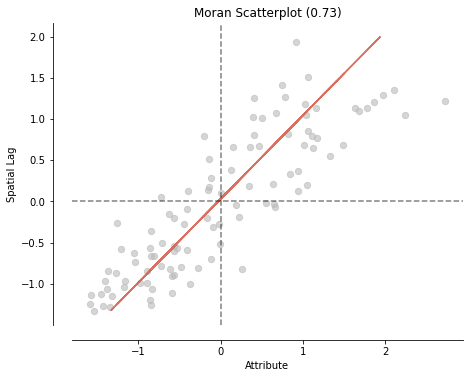

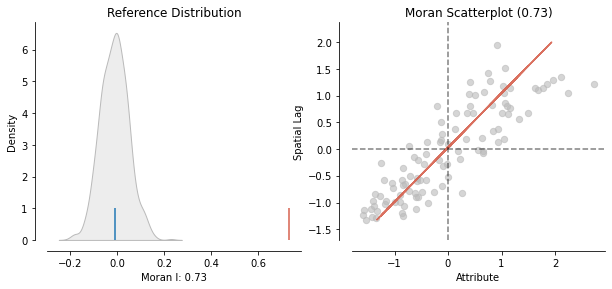

In [492]:
moran_scatterplot(mi);
plot_moran(mi);

## LISA

In [493]:
df_grouped_stadt

OBJECTID_x       LINREFX       LINREFY   XGCSWGS84    YGCSWGS84  \
0       6170234  3.282793e+07  3.441709e+08  579.777817  3105.932639   
1       2522647  1.359653e+07  1.423888e+08  240.091828  1284.972071   
2       5503962  3.220508e+07  3.382443e+08  568.925221  3052.456044   
3       6849751  3.440405e+07  3.619926e+08  607.931168  3266.776836   
4       7878806  3.230933e+07  3.382705e+08  570.504165  3052.678042   
..          ...           ...           ...         ...          ...   
96       135910  5.606487e+05  5.929637e+06    9.914586    53.512174   
97       969225  4.469135e+06  4.740530e+07   79.068668   427.813436   
98      3235430  1.670472e+07  1.777557e+08  295.683300  1604.179279   
99       414978  1.672851e+06  1.778593e+07   29.606071   160.510764   
100      547245  2.215311e+06  2.372253e+07   39.247630   214.087487   

     UKATEGORIE_1  UKATEGORIE_2  UKATEGORIE_3  UART_0  UART_1  ...  motor_std  \
0               0             8            50      14       0  ...   1.106428   
1               0             0            24       6       2  ...  -0.096902   
2               0             1            56      24       2  ...   0.865762   
3               0             5            56      19       1  ...   1.106428   
4               0             3            54      18       5  ...   0.625096   
..            ...           ...           ...     ...     ...  ...        ...   
96              0             0             1       1       0  ...  -1.059566   
97              0             1             7       2       0  ...  -0.498012   
98              0             6            24       6       0  ...   0.705318   
99              0             0             3       1       0  ...  -0.899122   
100             0             0             4       0       0  ...  -0.738678   

     w_motor_std  motor_ratio  w_motor_ratio  motor_ratio_std  \
0       0.368386     0.306897       0.458582        -0.651695   
1      -0.177124     0.458333       1.481593        -0.551411   
2       0.320253     0.301754       0.937781        -0.655100   
3       0.304208     0.278689       1.168607        -0.670375   
4       0.317579     0.301170       1.152707        -0.655488   
..           ...          ...            ...              ...   
96     -0.631715     5.333333       2.757464         2.676886   
97     -0.417790     1.000000       1.807778        -0.192712   
98     -0.711937     0.144444       1.750000        -0.759273   
99     -0.578234     2.000000       2.249528         0.469503   
100    -0.337568     2.250000       0.871277         0.635057   

     w_motor_ratio_std  count    w_count  count_std  w_count_std  
0            -0.551247     58  40.800000   1.482114     0.725508  
1             0.126206     24  24.000000  -0.013501    -0.013501  
2            -0.233914     57  37.800000   1.438125     0.593542  
3            -0.081057     61  37.400000   1.614080     0.575947  
4            -0.091587     57  33.166667   1.438125     0.389728  
..                 ...    ...        ...        ...          ...  
96            0.971107      1  13.166667  -1.025241    -0.490045  
97            0.342211      8  12.500000  -0.717320    -0.519371  
98            0.303949     30   5.000000   0.250431    -0.849286  
99            0.634744      3   8.666667  -0.937264    -0.687995  
100          -0.277954      4  13.333333  -0.893275    -0.482714  

[101 rows x 214 columns]

In [494]:
def plot_lisa(df, column, w, p=0.05):
    df_copy = df.copy()
    w_col = "w_" + column
    std_col = column + "_std"
    w_std_col = "w_" + column + "_std"
    df[w_col] = weights.lag_spatial(w, df[column])
    df[std_col] = (df[column] - df[column].mean()) / df[column].std()
    df[w_std_col] = weights.lag_spatial(w, df[std_col])
    lisa = esda.Moran_Local(df[w_std_col], w)
    # Break observations into significant or not
    df['significant'] = lisa.p_sim < p
    # Store the quadrant they belong to
    df['quadrant'] = lisa.q
    # calculate morans I 
    mi = esda.Moran(df[w_std_col], w)
    print(mi.I, mi.p_sim)
    plot_local_autocorrelation(lisa, df, w_std_col);

In [495]:
df_grouped_stadt['IstGkfz_1_ratio'] = df_grouped_stadt['IstGkfz_1'] / df_grouped_stadt['count']

0.2958470008686855 0.001


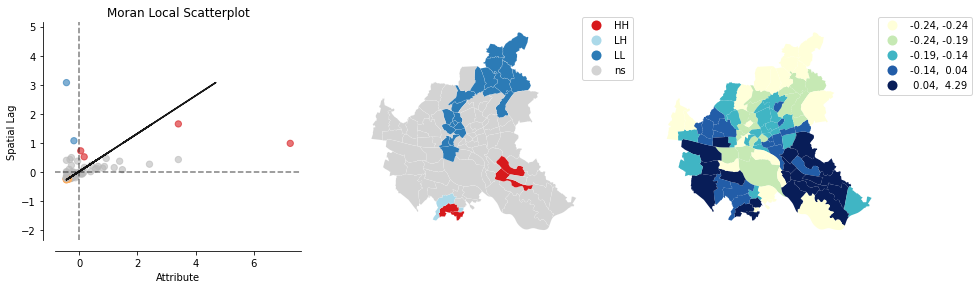

In [496]:
plot_lisa(df_grouped_stadt, "IstGkfz_1_ratio", w, p=0.05)

0.7312822383133449 0.001


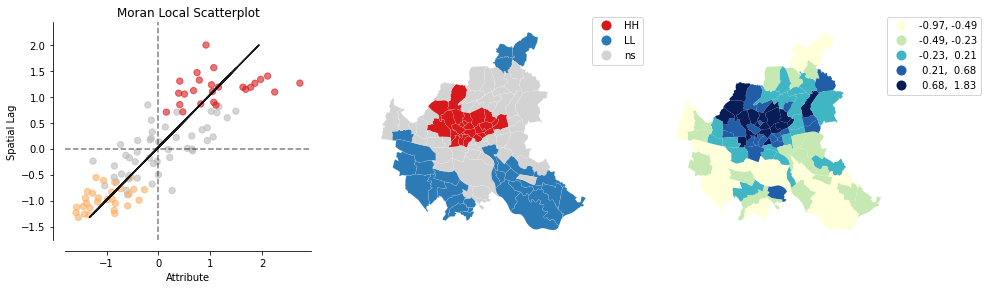

In [497]:
plot_lisa(df_grouped_stadt, "count", w, p=0.05)

In [498]:
df_grouped_stadt['UKATEGORIE_1_ratio'] = df_grouped_stadt['UKATEGORIE_1'] / df_grouped_stadt['count']
df_grouped_stadt['UKATEGORIE_2_ratio'] = df_grouped_stadt['UKATEGORIE_2'] / df_grouped_stadt['count']
df_grouped_stadt['UKATEGORIE_3_ratio'] = df_grouped_stadt['UKATEGORIE_3'] / df_grouped_stadt['count']

In [499]:
df_grouped_stadt['IstGkfz_1'].sum()

30

0.7312822383133449 0.001


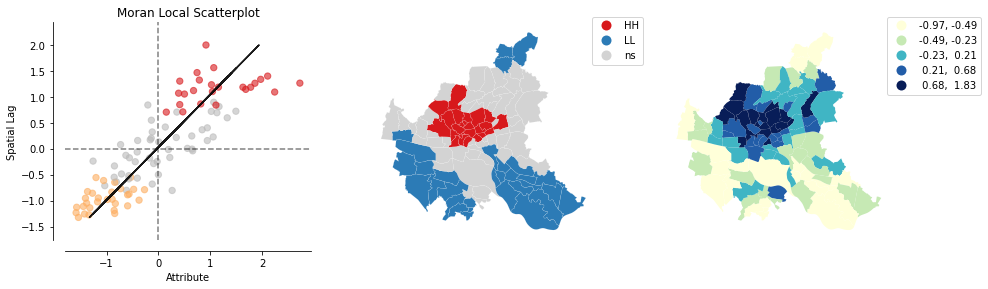

In [500]:
plot_lisa(df_grouped_stadt, "count", w, p=0.05)

In [501]:
#plot_lisa(df_grouped_stadt, "IstPKW_1_ratio", w, p=0.05)

0.3032621105455703 0.001


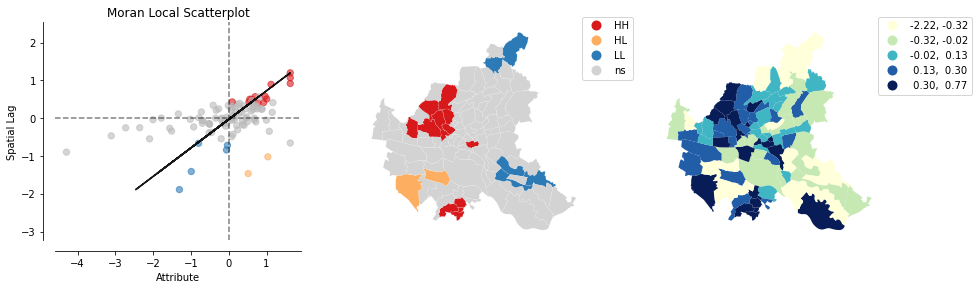

In [502]:
plot_lisa(df_grouped_stadt, "UKATEGORIE_3_ratio", w, p=0.05)

In [503]:
df_grouped_stadt["weekend"] = df_grouped_stadt["UWOCHENTAG_7"] + df_grouped_stadt["UWOCHENTAG_1"]
df_grouped_stadt["weekday"] = df_grouped_stadt["UWOCHENTAG_6"] + df_grouped_stadt["UWOCHENTAG_2"] + df_grouped_stadt["UWOCHENTAG_3"] + df_grouped_stadt["UWOCHENTAG_4"] + df_grouped_stadt["UWOCHENTAG_5"]

In [504]:
df_grouped_stadt['weekend_ratio'] = df_grouped_stadt['weekend'] / df_grouped_stadt['count']
df_grouped_stadt['weekday_ratio'] = df_grouped_stadt['weekday'] / df_grouped_stadt['count']

0.7081864575396307 0.001


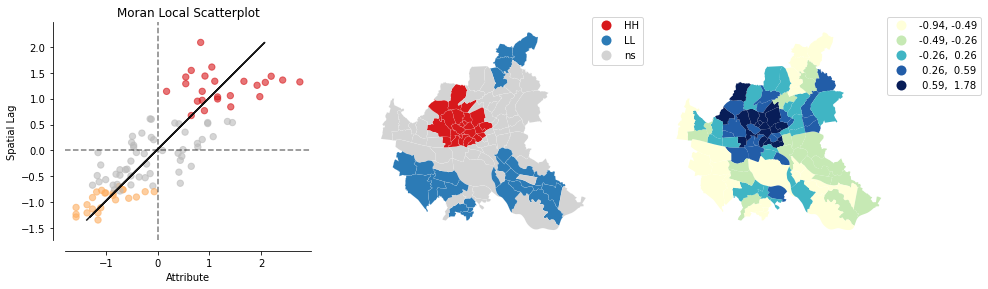

In [505]:
plot_lisa(df_grouped_stadt, "weekend", w, p=0.05)

In [506]:
cluster_districts = df_districts["stadttei_2"][df_districts['stadtteil_'].isin(["Reitbrook", "Kirchwerder", "Neuallermöhe", "Bergedorf", "Altengamme", "Ochsenwerder", "Neuengamme", "Curslack", "Allermöhe"])]

In [507]:
# add column "stadtteil_" to df_grouped_stadt from df_districts matching "stadttei_2"
df_grouped_stadt["stadtteil_"] = df_grouped_stadt["stadttei_2"].map(df_districts.set_index("stadttei_2")["stadtteil_"])

In [508]:
df_districts[["stadtteil_", "stadttei_2"]][df_districts['stadttei_2'].isin(cluster_districts)]

stadtteil_ stadttei_2
74     Bergedorf        602
75      Curslack        603
76    Altengamme        604
77    Neuengamme        605
78   Kirchwerder        606
79  Ochsenwerder        607
80     Reitbrook        608
81     Allermöhe        609
86  Neuallermöhe        614

In [509]:
# calculate area of each stadtteil in square meters
df_grouped_stadt["SHAPE_Area"] = df_grouped_stadt["geometry"].area
# area in sq km
df_grouped_stadt["SHAPE_Area"] = df_grouped_stadt["geometry"].area / 1000000
# calcluate count per square meter
df_grouped_stadt["count_per_sqkm"] = df_grouped_stadt["count"] / df_grouped_stadt["SHAPE_Area"]

In [510]:
# print value range for shapre_area and neighboorhod name
df_grouped_stadt[["SHAPE_Area", "stadtteil_"]].sort_values(by="SHAPE_Area")


SHAPE_Area          stadtteil_
19    0.548077        Sternschanze
41    0.565130        Hoheluft-Ost
35    0.719088       Hoheluft-West
90    0.792942           Langenbek
6     0.821506           Borgfelde
..         ...                 ...
17   19.628036        Finkenwerder
98   22.507116  Neugraben-Fischbek
71   26.548566           Rahlstedt
77   32.286891         Kirchwerder
13   35.362574        Wilhelmsburg

[101 rows x 2 columns]

0.867945618324733 0.001


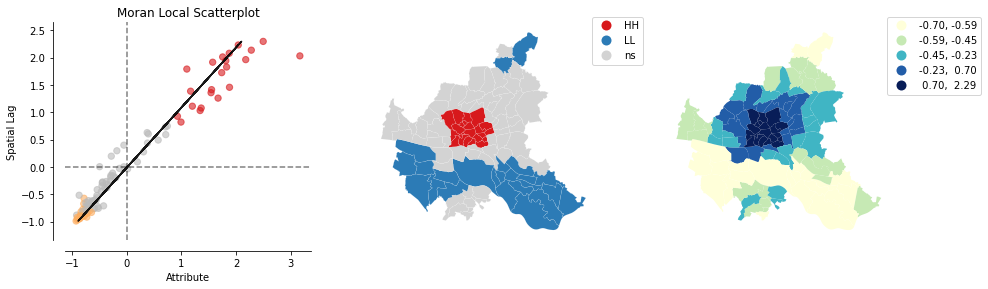

In [511]:
plot_lisa(df_grouped_stadt, "count_per_sqkm", w, p=0.05)

In [512]:
columns = ["count", "IstPKW_1", "IstPKW_0", "weekend", "weekday", "IstNurRad_1", "IstNurRad_0", "motor"]
for column in columns:
    df_grouped_stadt[column + "_per_sqkm"] = df_grouped_stadt[column] / df_grouped_stadt["SHAPE_Area"]

In [513]:
df_grouped_stadt['motor'].mean()

13.207920792079207

In [514]:
# get cwd
import os
cwd = os.getcwd()
print(cwd)
with open(f"{cwd}/work/table.txt", "w") as f:
    f.write(df_grouped_stadt[["count", "count_per_sqkm", "IstPKW_1", "weekend", "weekday", "IstNurRad_1", "stadtteil_", "stadttei_2", "SHAPE_Area"]].to_latex(index=False,float_format=lambda x: '%10.2f' % x))

/home/jovyan/work/gds-main


FileNotFoundError: [Errno 2] No such file or directory: '/home/jovyan/work/gds-main/work/table.txt'

0.8522736468500536 0.001


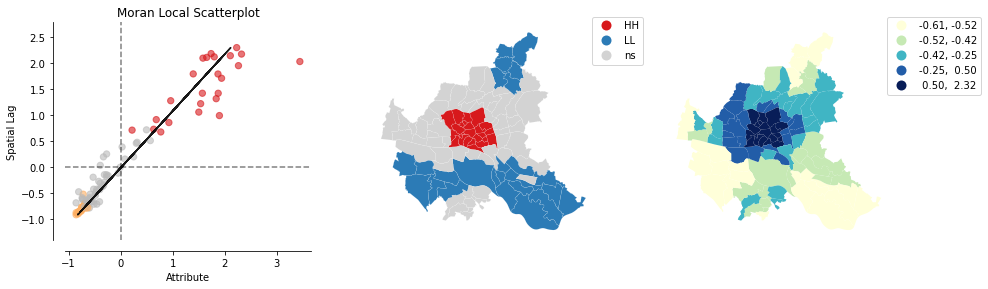

In [515]:
plot_lisa(df_grouped_stadt, "weekend_per_sqkm", w, p=0.05)

0.8665964391610907 0.001


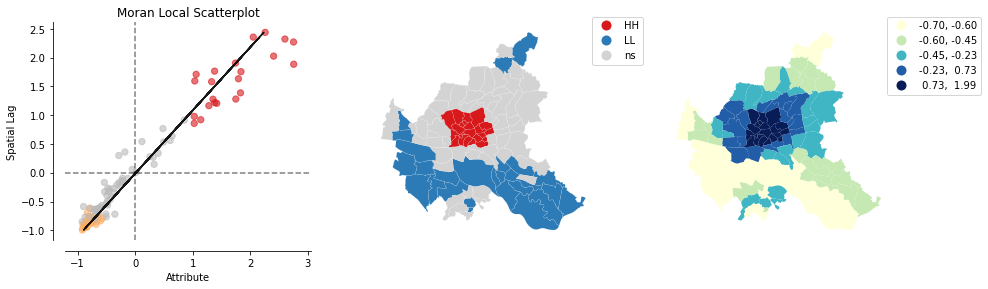

In [516]:
plot_lisa(df_grouped_stadt, "IstPKW_1_per_sqkm", w, p=0.05)

0.8668469915503217 0.001


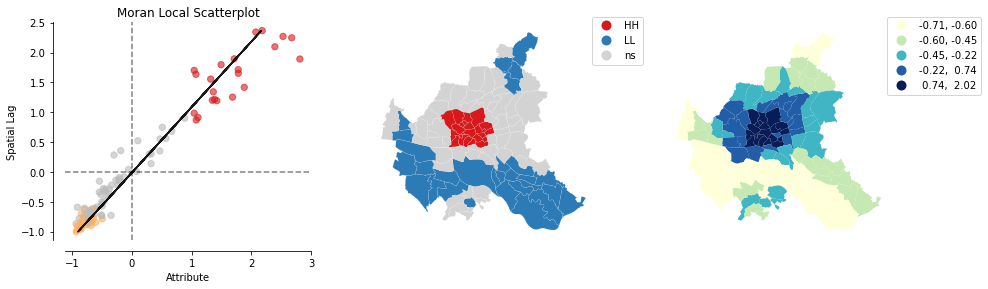

In [517]:
plot_lisa(df_grouped_stadt, "motor_per_sqkm", w, p=0.05)

0.8533398048585765 0.001


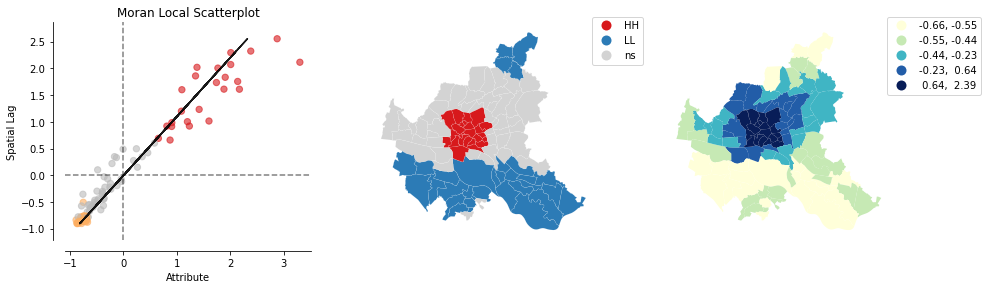

In [518]:
plot_lisa(df_grouped_stadt, "IstNurRad_1_per_sqkm", w, p=0.05)

## Point Pattern Analysis

0.867945618324733 0.001


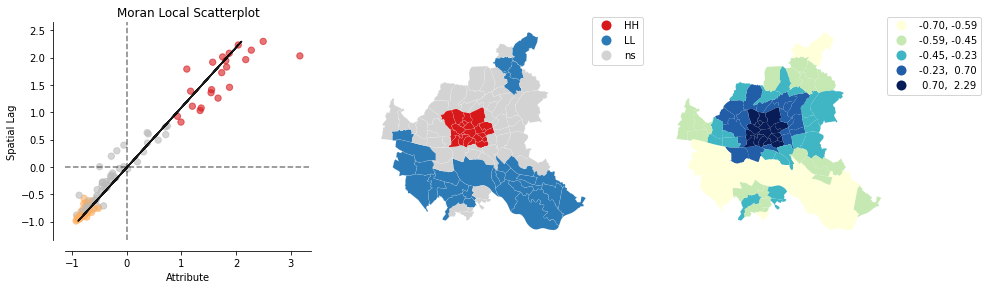

In [51]:
# Basis for the analysis
plot_lisa(df_grouped_stadt, "count_per_sqkm", w, p=0.05)

In [52]:
bike_copy = df_grouped_stadt.copy()
bike_copy['w_countpsqm'] = weights.lag_spatial(w, bike_copy["count_per_sqkm"])
bike_copy['std_countpsqm'] = (bike_copy["count_per_sqkm"] - bike_copy["count_per_sqkm"].mean()) / bike_copy["count_per_sqkm"].std()
bike_copy['w_std_countpsqm'] = weights.lag_spatial(w, bike_copy['std_countpsqm'])
lisa = esda.Moran_Local(bike_copy['w_std_countpsqm'], w)
bike_copy['lisa'] = lisa.Is
bike_copy['lisa_p'] = lisa.p_sim
bike_copy['lisa_q'] = lisa.q # 1 HH, 2 LH, 3 LL, 4 HL

In [133]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [53]:
sig_lisas = bike_copy[bike_copy['lisa_p'] < 0.05]#[['stadttei_2', 'stadtteil_', 'lisa', 'lisa_q', 'lisa_p']]

In [54]:
sig_lisas_hh = sig_lisas[sig_lisas['lisa_q'] == 1]

<AxesSubplot:>

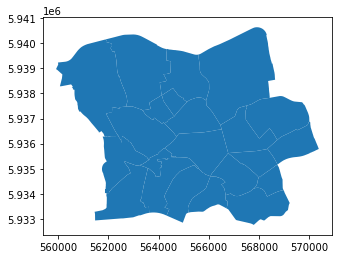

In [149]:
sig_lisas_hh.plot()

In [467]:
sig_lisas_hh.shape

(22, 113)

In [156]:
df_bike_hh.columns

Index(['OBJECTID', 'UIDENTSTLA', 'ULAND', 'UREGBEZ', 'UKREIS', 'UGEMEINDE',
       'UJAHR', 'UMONAT', 'USTUNDE', 'UWOCHENTAG', 'UKATEGORIE', 'UART',
       'UTYP1', 'ULICHTVERH', 'IstRad', 'IstPKW', 'IstFuss', 'IstKrad',
       'IstGkfz', 'IstSonstig', 'LINREFX', 'LINREFY', 'XGCSWGS84', 'YGCSWGS84',
       'USTRZUSTAN', 'geometry', 'IstNurRad', 'season', 'bezirk', 'stadtteil',
       'bezirk_id', 'stadtteil_id'],
      dtype='object')

In [55]:
center = df_bike_hh[df_bike_hh['stadtteil'].isin(sig_lisas_hh['stadtteil_'])]

In [161]:
df_districts.columns

Index(['OBJECTID', 'bezirk', 'bezirk_nam', 'stadtteil_', 'stadttei_1',
       'stadttei_2', 'SHAPE_Leng', 'SHAPE_Area', 'geometry'],
      dtype='object')

In [56]:
df_district_center = df_districts[df_districts['stadtteil_'].isin(sig_lisas_hh['stadtteil_'])]

<AxesSubplot:>

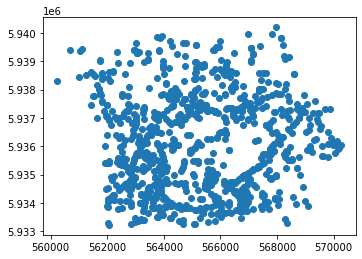

In [160]:
center.plot()

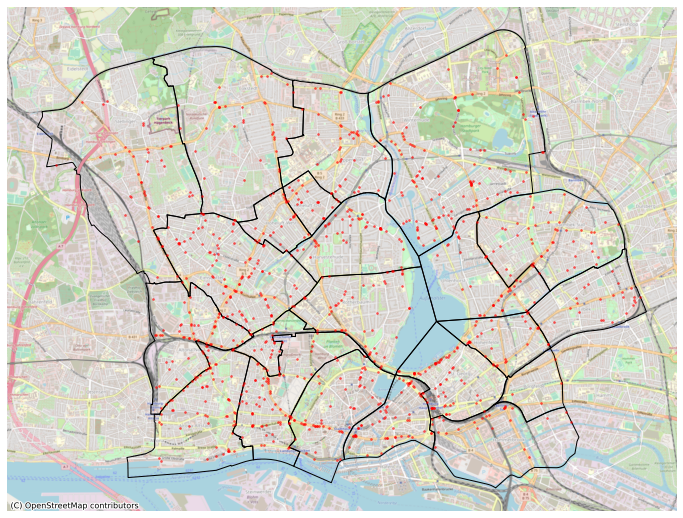

In [210]:
fig, ax = plt.subplots(1, figsize=(12,12)) # visualize with two different colors --> car involved vs no car involved

df_district_center.plot(ax=ax, facecolor='none', edgecolor='black')
center.plot(ax=ax, markersize=3, c="red", alpha=0.5,) #xkcd:bright yellow

ax.set_axis_off()

cx.add_basemap(
    ax, 
    crs=center.crs,
    source= cx.providers.OpenStreetMap.Mapnik # cx.providers.CartoDB.DarkMatter # providers.Stamen.Toner
)

plt.savefig('center_dotmap.png')

In [202]:
center['motor'] = np.where((center['IstKrad'] == '1') | (center['IstPKW'] == '1') | (center['IstGkfz'] == '1'), 'No motorized vehicle', 'Motorized vehicle')

/opt/conda/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [186]:
center['motor'].mean()

0.5274509803921569

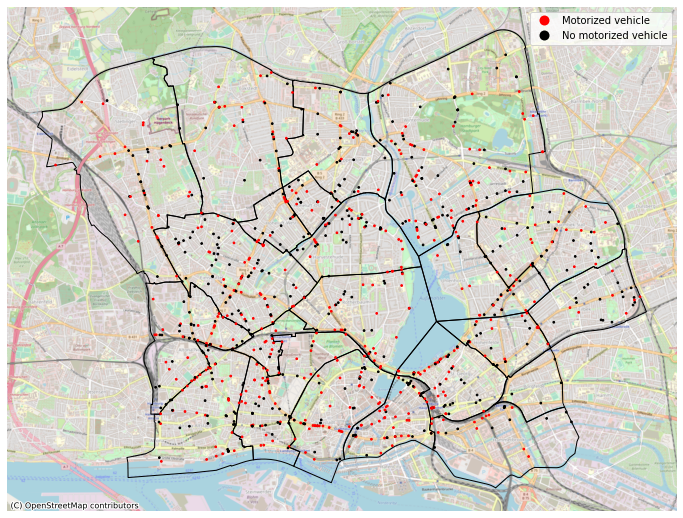

In [211]:
color_map = ListedColormap(["red", "black"])

fig, ax = plt.subplots(1, figsize=(12,12)) # visualize with two different colors --> car involved vs no car involved

df_district_center.plot(ax=ax, facecolor='none', edgecolor='black')
center.plot(column = 'motor', ax=ax, cmap = color_map, legend = True, categorical = True, markersize=3, alpha=1) #xkcd:bright yellow

ax.set_axis_off()

cx.add_basemap(
    ax, 
    crs=center.crs,
    source= cx.providers.OpenStreetMap.Mapnik # cx.providers.CartoDB.DarkMatter # providers.Stamen.Toner
)

plt.savefig('center_dotmapMotor.png')

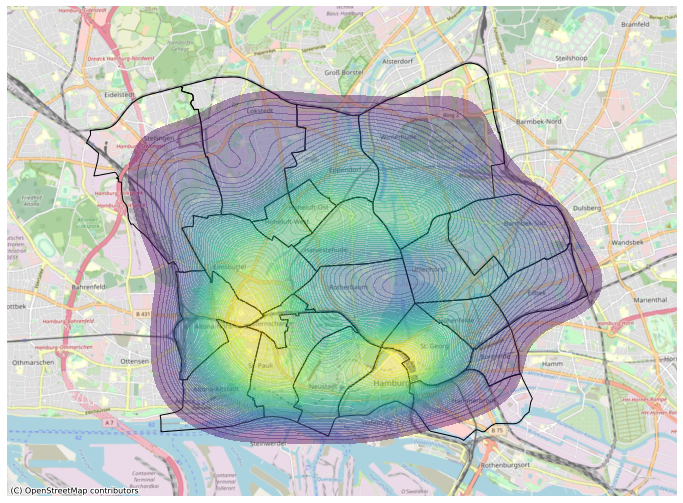

In [212]:
fig, ax = plt.subplots(1, figsize=(12,12))

df_district_center.plot(ax=ax, facecolor='none', edgecolor='black')
#center.plot(ax=ax, markersize=2, c="red", alpha=0.5,) #xkcd:bright yellow
sns.kdeplot(
    x=center['LINREFX'], 
    y=center['LINREFY'], 
    n_levels=50, 
    fill=True,
    alpha=0.4,
    cmap="viridis", 
    ax = ax
)

ax.set_axis_off()

cx.add_basemap(
    ax, 
    crs=center.crs,
    source= cx.providers.OpenStreetMap.Mapnik#providers.Stamen.Toner # cx.providers.CartoDB.DarkMatter
)

plt.savefig('center_kde.png')

In [135]:
G = ox.graph_from_address(
    address="32 Rothenbaumchaussee, Hamburg",
    dist=7000,
    dist_type="network",
    network_type="all",
)

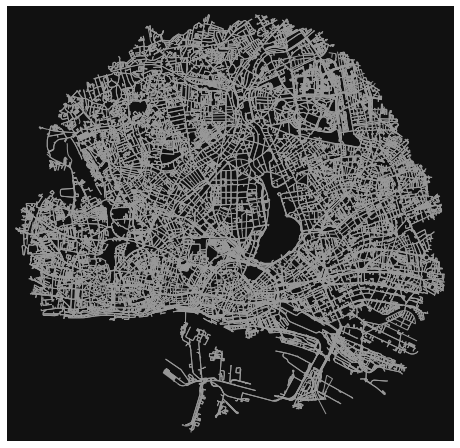

<Figure size 432x288 with 0 Axes>

In [213]:
ox.plot_graph(G, node_size = 0)
plt.savefig('streetnetwork.png')

In [303]:
center_nodes, center_edges = ox.utils_graph.graph_to_gdfs(G, 
                                      nodes = True, 
                                      edges = True, 
                                      node_geometry = True,
                                      fill_edge_geometry = True)

In [304]:
center_edges = center_edges.to_crs(center.crs)
center_edges = center_edges.rename_geometry('geometry_street')

In [295]:
G.graph['crs']

'epsg:4326'

In [297]:
G_crs = ox.projection.project_graph(G, to_crs=center.crs)

In [298]:
G_crs.graph['crs']

<Derived Projected CRS: EPSG:25832>
Name: ETRS89 / UTM zone 32N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Europe between 6°E and 12°E: Austria; Belgium; Denmark - onshore and offshore; Germany - onshore and offshore; Norway including - onshore and offshore; Spain - offshore.
- bounds: (6.0, 38.76, 12.0, 84.33)
Coordinate Operation:
- name: UTM zone 32N
- method: Transverse Mercator
Datum: European Terrestrial Reference System 1989 ensemble
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [311]:
cols = center_edges.columns.to_list()
cols.extend(center.columns.to_list())

df_nearest_edges = pd.DataFrame(columns = cols)
dist = []

count = 0

for i in range(len(center)):
    edge = ox.distance.nearest_edges(G_crs, center['LINREFX'].iloc[i], center['LINREFY'].iloc[i], return_dist = True)
    df_nearest_edges.loc[i,:] = pd.concat([center_edges.loc[edge[0]], center.iloc[i]])
    dist.append(edge[1])
    count += 1
    if count%10 == 0:
        print(count)
                                           
        
df_nearest_edges.to_csv('matchednearest_edge.csv')

10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020


In [317]:
df_nearest_edges['highway'] = [tuple(x) if type(x) == list else x for x in df_nearest_edges['highway']]
df_nearest_edges['name'] = [tuple(x) if type(x) == list else x for x in df_nearest_edges['name']]

In [318]:
pd.crosstab(df_nearest_edges['highway'], df_nearest_edges['motor'])

motor                         Motorized vehicle  No motorized vehicle
highway                                                              
(cycleway, secondary_link)                    1                     1
(residential, living_street)                  0                     2
(residential, pedestrian)                     2                     1
(steps, footway)                              1                     3
corridor                                      1                     1
cycleway                                      5                     9
footway                                      27                    42
path                                          7                    13
pedestrian                                    2                     0
primary                                     101                    82
primary_link                                  0                     1
residential                                 140                   168
secondary                                    72                    69
secondary_link                                1                     1
service                                      20                    14
tertiary                                     85                   116
tertiary_link                                 1                     1
unclassified                                 16                    14

In [320]:
df_nearest_edges['highway'].value_counts()

residential                     308
tertiary                        201
primary                         183
secondary                       141
footway                          69
service                          34
unclassified                     30
path                             20
cycleway                         14
(steps, footway)                  4
(residential, pedestrian)         3
secondary_link                    2
tertiary_link                     2
(residential, living_street)      2
(cycleway, secondary_link)        2
pedestrian                        2
corridor                          2
primary_link                      1
Name: highway, dtype: int64

In [470]:
center_edges['highway'].value_counts()

footway                            54717
service                            20289
residential                        18430
path                                6927
tertiary                            5269
                                   ...  
[steps, service, footway, path]        1
[path, steps, footway, service]        1
[cycleway, secondary_link]             1
[trunk, motorway]                      1
[steps, service, pedestrian]           1
Name: highway, Length: 88, dtype: int64

In [323]:
df_nearest_edges['name'].value_counts() # filter for more than 10

Kieler Straße                            19
Max-Brauer-Allee                         18
Eppendorfer Weg                          16
Harvestehuder Weg                        15
An der Alster                            14
                                         ..
Admiralitätstraße                         1
Behnstraße                                1
Lenhartzstraße                            1
Weidenstieg                               1
(Große Theaterstraße, Fehlandtstraße)     1
Name: name, Length: 410, dtype: int64

In [324]:
pd.crosstab(df_nearest_edges['name'], df_nearest_edges['motor'])

motor                                               Motorized vehicle  \
name                                                                    
(Amsinckstraße, Willy-Brandt-Straße, Deichtortu...                  0   
(Große Bahnstraße, Waidmannstraße)                                  1   
(Große Theaterstraße, Fehlandtstraße)                               0   
(Gänsemarkt, Jungfernstieg)                                         1   
(Neuer Pferdemarkt, Budapester Straße)                              0   
...                                                               ...   
Wördemanns Weg                                                      1   
Zeughausmarkt                                                       1   
Zimmerstraße                                                        0   
Zippelhaus                                                          1   
Övelgönner Straße                                                   0   

motor                                               No motorized vehicle  
name                                                                      
(Amsinckstraße, Willy-Brandt-Straße, Deichtortu...                     1  
(Große Bahnstraße, Waidmannstraße)                                     0  
(Große Theaterstraße, Fehlandtstraße)                                  1  
(Gänsemarkt, Jungfernstieg)                                            0  
(Neuer Pferdemarkt, Budapester Straße)                                 2  
...                                                                  ...  
Wördemanns Weg                                                         0  
Zeughausmarkt                                                          0  
Zimmerstraße                                                           1  
Zippelhaus                                                             0  
Övelgönner Straße                                                      1  

[410 rows x 2 columns]

In [325]:
street_names = df_nearest_edges['name'].value_counts()[df_nearest_edges['name'].value_counts() >= 10].index
ind = [i for i, acc in enumerate(df_nearest_edges['name']) if acc in street_names]
df_nearest_10 = df_nearest_edges.iloc[ind]

In [327]:
df_nearest_10.name.value_counts()

Kieler Straße           19
Max-Brauer-Allee        18
Eppendorfer Weg         16
Harvestehuder Weg       15
Stresemannstraße        14
An der Alster           14
Barmbeker Straße        11
Ludwig-Erhard-Straße    10
Sierichstraße           10
Name: name, dtype: int64

In [328]:
pd.crosstab(df_nearest_10['name'], df_nearest_10['motor'])

motor                 Motorized vehicle  No motorized vehicle
name                                                         
An der Alster                        11                     3
Barmbeker Straße                      7                     4
Eppendorfer Weg                       7                     9
Harvestehuder Weg                     9                     6
Kieler Straße                         5                    14
Ludwig-Erhard-Straße                  9                     1
Max-Brauer-Allee                     12                     6
Sierichstraße                         4                     6
Stresemannstraße                      7                     7

In [340]:
df_nearest_edges['high_count'] = 0
df_nearest_edges['high_count'].iloc[ind] = 1

/tmp/ipykernel_5406/1187755223.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nearest_edges['high_count'].iloc[ind] = 1


In [341]:
df_nearest_edges['high_count'].mean()

0.12450980392156863

In [349]:
## Add edge attribute
# in order to loop over, has to be converted into tuple
center_edges['name'] = [tuple(x) if type(x) == list else x for x in center_edges['name']]

In [351]:
center_edges = center_edges.to_crs('EPSG:4326')
center_edges = center_edges.rename_geometry('geometry')

ind = [i for i, acc in enumerate(center_edges['name']) if acc in street_names]

center_edges['high_count'] = 0
center_edges['high_count'].iloc[ind] = 1

/tmp/ipykernel_5406/737781045.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  center_edges['high_count'].iloc[ind] = 1


In [353]:
# convert back into list
center_edges['name'] = [list(x) if type(x) == tuple else x for x in center_edges['name']]

In [354]:
# Get graph with new attribute
G_newatt = ox.graph_from_gdfs(center_nodes, center_edges)

In [360]:
center_edges['high_count'].value_counts()

0    126587
1      1025
Name: high_count, dtype: int64

In [356]:
# Check whether new attribute is in graph attributes
for u, v, k, d in G_newatt.edges(keys=True, data=True):
    print(d)
    break

{'osmid': 4928829, 'oneway': True, 'lanes': '2', 'highway': 'trunk_link', 'length': 24.463, 'geometry': <shapely.geometry.linestring.LineString object at 0x7fb4904c6550>, 'high_count': 0}


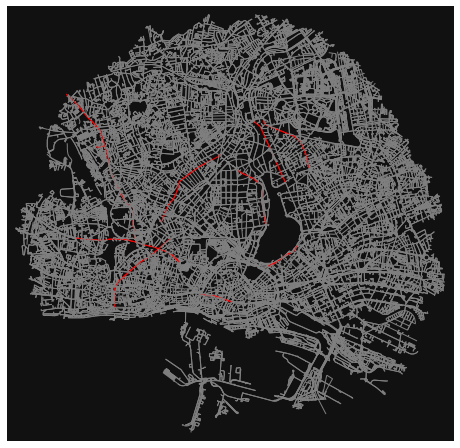

<Figure size 432x288 with 0 Axes>

In [364]:
color_map = ListedColormap(["gray", "red"])
edge_types = df_nearest_edges['high_count'].value_counts()
color_list = ox.plot.get_colors(n=len(edge_types), cmap=color_map)
color_mapper = pd.Series(color_list, index=edge_types.index).to_dict()

# get the color for each edge based on its highway type
ec = [color_mapper[d['high_count']] for u, v, k, d in G_newatt.edges(keys=True, data=True)]
fig, ax = ox.plot_graph(G_newatt, edge_color=ec, node_size = 0)
plt.savefig('street_network_high_count.png')

In [521]:
pd.DataFrame(center_edges).to_csv('center_edges.csv')
pd.DataFrame(center_nodes).to_csv('center_nodes.csv')